### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:72.5% !important; }</style>"))

In [2]:
import os
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split

from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor

from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='r2',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15, 8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

    plt.title(f'Learning curves ({type(estimator).__name__})')
    plt.xlabel('Training examples')
    plt.ylabel('Score')     
    plt.legend(loc='best')
    plt.grid()
    plt.show()

### Пути к директориям и файлам

In [6]:
# from google.colab import files
# uploaded = files.upload()

In [7]:
TRAIN_DATASET_PATH2 = './contract-results/SiM1.csv' # Фьючерсный контракт на курс доллар США - российский рубль
TRAIN_DATASET_PATH3 = './contract-results/RIM1.csv' # Фьючерсный контракт на Индекс РТС
TRAIN_DATASET_PATH4 = './contract-results/BRM1.csv' # Фьючерсный контракт на нефть Brent
TRAIN_DATASET_PATH5 = './contract-results/EuM1.csv' # Фьючерсный контракт на курс евро-российский рубль
TRAIN_DATASET_PATH7 = './contract-results/GDM1.csv' # Фьючерсный контракт на золото
TRAIN_DATASET_PATH8 = './contract-results/SRM1.csv' # Фьючерсный контракт на обыкновенные акции ПАО Сбербанк
TRAIN_DATASET_PATH9 = './contract-results/SVM1.csv' # Фьючерсный контракт на серебро
TRAIN_DATASET_PATH10 = './contract-results/MXM1.csv' # Фьючерсный контракт на Индекс МосБиржи
TRAIN_DATASET_PATH11 = './contract-results/GZM1.csv' # Фьючерсный контракт на обыкновенные акции ПАО «Газпром»
TRAIN_DATASET_PATH12 = './contract-results/LKM1.csv' # Фьючерсный контракт на обыкновенные акции ПАО «НК «ЛУКОЙЛ»
TRAIN_DATASET_PATH13 = './contract-results/RNM1.csv' # Фьючерсный контракт на обыкновенные акции ПАО «НК «Роснефть»

### Загрузка данных

In [8]:
SiM1 = pd.read_csv(TRAIN_DATASET_PATH2, encoding='windows-1251')
RIM1 = pd.read_csv(TRAIN_DATASET_PATH3, encoding='windows-1251')
BRM1 = pd.read_csv(TRAIN_DATASET_PATH4, encoding='windows-1251')
EuM1 = pd.read_csv(TRAIN_DATASET_PATH5, encoding='windows-1251')
GDM1 = pd.read_csv(TRAIN_DATASET_PATH7, encoding='windows-1251')
SRM1 = pd.read_csv(TRAIN_DATASET_PATH8, encoding='windows-1251')
SVM1 = pd.read_csv(TRAIN_DATASET_PATH9, encoding='windows-1251')
MXM1 = pd.read_csv(TRAIN_DATASET_PATH10, encoding='windows-1251')
GZM1 = pd.read_csv(TRAIN_DATASET_PATH11, encoding='windows-1251')
LKM1 = pd.read_csv(TRAIN_DATASET_PATH12, encoding='windows-1251')
RNM1 = pd.read_csv(TRAIN_DATASET_PATH13, encoding='windows-1251')

### Изучение файла - SRM1.csv (Фьючерсный контракт на обыкновенные акции ПАО Сбербанк)

In [9]:
# Преобразование из объекта в тип данных дата и указание, что даты начинаются с дня, а не месяца
SRM1['Дата'] = pd.to_datetime(SRM1['Дата'], dayfirst=True)

In [10]:
SRM1['Дата'].head()

0   2020-06-08
1   2020-06-09
2   2020-06-10
3   2020-06-11
4   2020-06-15
Name: Дата, dtype: datetime64[ns]

In [11]:
SRM1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Дата                            233 non-null    datetime64[ns]
 1   Средне-взвешенная цена за лот   177 non-null    float64       
 2   Расчетная цена                  233 non-null    int64         
 3   Цена первой сделки              177 non-null    float64       
 4   Максим. цена                    177 non-null    float64       
 5   Миним. цена                     177 non-null    float64       
 6   Цена последней сделки           177 non-null    float64       
 7   Изменение                       158 non-null    float64       
 8   Объем последней сделки, контр.  177 non-null    float64       
 9   Число сделок                    177 non-null    float64       
 10  Объем торгов, руб.              177 non-null    float64       
 11  Объем 

### Извлечение данных по фьючерсным контрактам

In [12]:
directory = './derivatives-open-positions'

In [13]:
files = os.listdir(directory)
TRAIN_DATASET_PATH = directory + '/'

In [14]:
derivatives = pd.DataFrame()
derivatives_brent = pd.DataFrame()
derivatives_SiM1 = pd.DataFrame()
derivatives_EuM1 = pd.DataFrame()
derivatives_RIM1 = pd.DataFrame()
derivatives_GDM1 = pd.DataFrame()
derivatives_SVM1 = pd.DataFrame()
derivatives_MXM1 = pd.DataFrame()
derivatives_GZM1 = pd.DataFrame()
derivatives_LKM1 = pd.DataFrame()
derivatives_RNM1 = pd.DataFrame()

for name in files:
    # Удаление пустых или малозначимых столбцов
    derivatives_tmp = pd.read_csv(TRAIN_DATASET_PATH + name)
    derivatives_tmp['moment'] = derivatives_tmp['moment'].astype('datetime64[ns]')
    derivatives_tmp.drop('contract_type', axis=1, inplace=True)
    # derivatives_tmp.drop('iz_fiz', axis=1, inplace=True)
    derivatives_tmp.drop('change_prev_week_short_perc', axis=1, inplace=True)
    derivatives_tmp.drop('change_prev_week_long_perc', axis=1, inplace=True)
    derivatives_tmp.drop('Unnamed: 13', axis=1, inplace=True)
    # Изменение последовательности столбцов
    derivatives_tmp = derivatives_tmp[['moment', 'isin', 'name', 'iz_fiz', 'long_position', 'short_position', 'change_prev_week_long_abs', 'change_prev_week_short_abs', 'clients_in_long', 'clients_in_short']]
    
    # Фьючерсный контракт на обыкновенные акции ПАО Сбербанк
    SRM1_tmp = derivatives_tmp[derivatives_tmp['name'] == 'Фьючерсный контракт на обыкновенные акции ПАО Сбербанк']
    # Отбор физических и юридических лиц, по признаку
    SRM1_ind = SRM1_tmp[SRM1_tmp['iz_fiz'] == 1]
    SRM1_ent = SRM1_tmp[SRM1_tmp['iz_fiz'] != 1]
    # Объединение датафреймов
    SRM1_tmp = pd.merge(SRM1_ind, SRM1_ent, how='outer', on=['moment', 'isin', 'name'], suffixes=('_ind', '_ent'))
    SRM1_tmp.drop('iz_fiz_ind', axis=1, inplace=True)
    SRM1_tmp.drop('iz_fiz_ent', axis=1, inplace=True)
    derivatives = derivatives.append(SRM1_tmp, ignore_index = True)
    
    # Фьючерсный контракт на нефть BRENT
    BRM1_tmp = derivatives_tmp[derivatives_tmp['name'] == 'Фьючерсный контракт на нефть BRENT']
    # Отбор физических и юридических лиц, по признаку
    BRM1_ind = BRM1_tmp[BRM1_tmp['iz_fiz'] == 1]
    BRM1_ent = BRM1_tmp[BRM1_tmp['iz_fiz'] != 1]
    # Объединение датафреймов
    BRM1_tmp = pd.merge(BRM1_ind, BRM1_ent, how='outer', on=['moment', 'isin', 'name'], suffixes=('_brent_ind', '_brent_ent'))
    BRM1_tmp.drop('iz_fiz_brent_ind', axis=1, inplace=True)
    BRM1_tmp.drop('iz_fiz_brent_ent', axis=1, inplace=True)
    BRM1_tmp.drop('change_prev_week_long_abs_brent_ind', axis=1, inplace=True)
    BRM1_tmp.drop('change_prev_week_short_abs_brent_ind', axis=1, inplace=True)
    BRM1_tmp.drop('change_prev_week_long_abs_brent_ent', axis=1, inplace=True)
    BRM1_tmp.drop('change_prev_week_short_abs_brent_ent', axis=1, inplace=True)
    derivatives_brent = derivatives_brent.append(BRM1_tmp, ignore_index = True)
    
    # Фьючерсный контракт на курс доллар США - российский рубль
    SiM1_tmp = derivatives_tmp[derivatives_tmp['name'] == 'Фьючерсный контракт на курс доллар США - российский рубль']
    # Отбор физических и юридических лиц, по признаку
    SiM1_ind = SiM1_tmp[SiM1_tmp['iz_fiz'] == 1]
    SiM1_ent = SiM1_tmp[SiM1_tmp['iz_fiz'] != 1]
    # Объединение датафреймов
    SiM1_tmp = pd.merge(SiM1_ind, SiM1_ent, how='outer', on=['moment', 'isin', 'name'], suffixes=('_SiM1_ind', '_SiM1_ent'))
    SiM1_tmp.drop('iz_fiz_SiM1_ind', axis=1, inplace=True)
    SiM1_tmp.drop('iz_fiz_SiM1_ent', axis=1, inplace=True)
    SiM1_tmp.drop('change_prev_week_long_abs_SiM1_ind', axis=1, inplace=True)
    SiM1_tmp.drop('change_prev_week_short_abs_SiM1_ind', axis=1, inplace=True)
    SiM1_tmp.drop('change_prev_week_long_abs_SiM1_ent', axis=1, inplace=True)
    SiM1_tmp.drop('change_prev_week_short_abs_SiM1_ent', axis=1, inplace=True)
    derivatives_SiM1 = derivatives_SiM1.append(SiM1_tmp, ignore_index = True)
    
    # Фьючерсный контракт на курс евро-российский рубль
    EuM1_tmp = derivatives_tmp[derivatives_tmp['name'] == 'Фьючерсный контракт на курс доллар США - российский рубль']
    # Отбор физических и юридических лиц, по признаку
    EuM1_ind = EuM1_tmp[EuM1_tmp['iz_fiz'] == 1]
    EuM1_ent = EuM1_tmp[EuM1_tmp['iz_fiz'] != 1]
    # Объединение датафреймов
    EuM1_tmp = pd.merge(EuM1_ind, EuM1_ent, how='outer', on=['moment', 'isin', 'name'], suffixes=('_EuM1_ind', '_EuM1_ent'))
    EuM1_tmp.drop('iz_fiz_EuM1_ind', axis=1, inplace=True)
    EuM1_tmp.drop('iz_fiz_EuM1_ent', axis=1, inplace=True)
    EuM1_tmp.drop('change_prev_week_long_abs_EuM1_ind', axis=1, inplace=True)
    EuM1_tmp.drop('change_prev_week_short_abs_EuM1_ind', axis=1, inplace=True)
    EuM1_tmp.drop('change_prev_week_long_abs_EuM1_ent', axis=1, inplace=True)
    EuM1_tmp.drop('change_prev_week_short_abs_EuM1_ent', axis=1, inplace=True)
    derivatives_EuM1 = derivatives_EuM1.append(EuM1_tmp, ignore_index = True)
    
    # Фьючерсный контракт на Индекс РТС
    RIM1_tmp = derivatives_tmp[derivatives_tmp['name'] == 'Фьючерсный контракт на Индекс РТС']
    # Отбор физических и юридических лиц, по признаку
    RIM1_ind = RIM1_tmp[RIM1_tmp['iz_fiz'] == 1]
    RIM1_ent = RIM1_tmp[RIM1_tmp['iz_fiz'] != 1]
    # Объединение датафреймов
    RIM1_tmp = pd.merge(RIM1_ind, RIM1_ent, how='outer', on=['moment', 'isin', 'name'], suffixes=('_RIM1_ind', '_RIM1_ent'))
    RIM1_tmp.drop('iz_fiz_RIM1_ind', axis=1, inplace=True)
    RIM1_tmp.drop('iz_fiz_RIM1_ent', axis=1, inplace=True)
    RIM1_tmp.drop('change_prev_week_long_abs_RIM1_ind', axis=1, inplace=True)
    RIM1_tmp.drop('change_prev_week_short_abs_RIM1_ind', axis=1, inplace=True)
    RIM1_tmp.drop('change_prev_week_long_abs_RIM1_ent', axis=1, inplace=True)
    RIM1_tmp.drop('change_prev_week_short_abs_RIM1_ent', axis=1, inplace=True)
    derivatives_RIM1 = derivatives_RIM1.append(RIM1_tmp, ignore_index = True)
    
    # Фьючерсный контракт на аффинированное золото в слитках
    GDM1_tmp = derivatives_tmp[derivatives_tmp['name'] == 'Фьючерсный контракт на аффинированное золото в слитках']
    # Отбор физических и юридических лиц, по признаку
    GDM1_ind = GDM1_tmp[GDM1_tmp['iz_fiz'] == 1]
    GDM1_ent = GDM1_tmp[GDM1_tmp['iz_fiz'] != 1]
    # Объединение датафреймов
    GDM1_tmp = pd.merge(GDM1_ind, GDM1_ent, how='outer', on=['moment', 'isin', 'name'], suffixes=('_GDM1_ind', '_GDM1_ent'))
    GDM1_tmp.drop('iz_fiz_GDM1_ind', axis=1, inplace=True)
    GDM1_tmp.drop('iz_fiz_GDM1_ent', axis=1, inplace=True)
    GDM1_tmp.drop('change_prev_week_long_abs_GDM1_ind', axis=1, inplace=True)
    GDM1_tmp.drop('change_prev_week_short_abs_GDM1_ind', axis=1, inplace=True)
    GDM1_tmp.drop('change_prev_week_long_abs_GDM1_ent', axis=1, inplace=True)
    GDM1_tmp.drop('change_prev_week_short_abs_GDM1_ent', axis=1, inplace=True)
    derivatives_GDM1 = derivatives_GDM1.append(GDM1_tmp, ignore_index = True)
    
    # Фьючерсный контракт на аффинированное серебро в слитках
    SVM1_tmp = derivatives_tmp[derivatives_tmp['name'] == 'Фьючерсный контракт на аффинированное серебро в слитках']
    # Отбор физических и юридических лиц, по признаку
    SVM1_ind = SVM1_tmp[SVM1_tmp['iz_fiz'] == 1]
    SVM1_ent = SVM1_tmp[SVM1_tmp['iz_fiz'] != 1]
    # Объединение датафреймов
    SVM1_tmp = pd.merge(SVM1_ind, SVM1_ent, how='outer', on=['moment', 'isin', 'name'], suffixes=('_SVM1_ind', '_SVM1_ent'))
    SVM1_tmp.drop('iz_fiz_SVM1_ind', axis=1, inplace=True)
    SVM1_tmp.drop('iz_fiz_SVM1_ent', axis=1, inplace=True)
    SVM1_tmp.drop('change_prev_week_long_abs_SVM1_ind', axis=1, inplace=True)
    SVM1_tmp.drop('change_prev_week_short_abs_SVM1_ind', axis=1, inplace=True)
    SVM1_tmp.drop('change_prev_week_long_abs_SVM1_ent', axis=1, inplace=True)
    SVM1_tmp.drop('change_prev_week_short_abs_SVM1_ent', axis=1, inplace=True)
    derivatives_SVM1 = derivatives_SVM1.append(SVM1_tmp, ignore_index = True)
    
    # Фьючерсный контракт на Индекс МосБиржи
    MXM1_tmp = derivatives_tmp[derivatives_tmp['name'] == 'Фьючерсный контракт на Индекс МосБиржи']
    # Отбор физических и юридических лиц, по признаку
    MXM1_ind = MXM1_tmp[MXM1_tmp['iz_fiz'] == 1]
    MXM1_ent = MXM1_tmp[MXM1_tmp['iz_fiz'] != 1]
    # Объединение датафреймов
    MXM1_tmp = pd.merge(MXM1_ind, MXM1_ent, how='outer', on=['moment', 'isin', 'name'], suffixes=('_MXM1_ind', '_MXM1_ent'))
    MXM1_tmp.drop('iz_fiz_MXM1_ind', axis=1, inplace=True)
    MXM1_tmp.drop('iz_fiz_MXM1_ent', axis=1, inplace=True)
    MXM1_tmp.drop('change_prev_week_long_abs_MXM1_ind', axis=1, inplace=True)
    MXM1_tmp.drop('change_prev_week_short_abs_MXM1_ind', axis=1, inplace=True)
    MXM1_tmp.drop('change_prev_week_long_abs_MXM1_ent', axis=1, inplace=True)
    MXM1_tmp.drop('change_prev_week_short_abs_MXM1_ent', axis=1, inplace=True)
    derivatives_MXM1 = derivatives_MXM1.append(MXM1_tmp, ignore_index = True)
    
    # Фьючерсный контракт на обыкновенные акции ПАО "Газпром"
    GZM1_tmp = derivatives_tmp[derivatives_tmp['name'] == 'Фьючерсный контракт на обыкновенные акции ПАО "Газпром"']
    # Отбор физических и юридических лиц, по признаку
    GZM1_ind = GZM1_tmp[GZM1_tmp['iz_fiz'] == 1]
    GZM1_ent = GZM1_tmp[GZM1_tmp['iz_fiz'] != 1]
    # Объединение датафреймов
    GZM1_tmp = pd.merge(GZM1_ind, GZM1_ent, how='outer', on=['moment', 'isin', 'name'], suffixes=('_GZM1_ind', '_GZM1_ent'))
    GZM1_tmp.drop('iz_fiz_GZM1_ind', axis=1, inplace=True)
    GZM1_tmp.drop('iz_fiz_GZM1_ent', axis=1, inplace=True)
    GZM1_tmp.drop('change_prev_week_long_abs_GZM1_ind', axis=1, inplace=True)
    GZM1_tmp.drop('change_prev_week_short_abs_GZM1_ind', axis=1, inplace=True)
    GZM1_tmp.drop('change_prev_week_long_abs_GZM1_ent', axis=1, inplace=True)
    GZM1_tmp.drop('change_prev_week_short_abs_GZM1_ent', axis=1, inplace=True)
    derivatives_GZM1 = derivatives_GZM1.append(GZM1_tmp, ignore_index = True)
    
    # Фьючерсный контракт на обыкновенные акции ПАО "НК "ЛУКОЙЛ"
    LKM1_tmp = derivatives_tmp[derivatives_tmp['name'] == 'Фьючерсный контракт на обыкновенные акции ПАО "НК "ЛУКОЙЛ"']
    # Отбор физических и юридических лиц, по признаку
    LKM1_ind = LKM1_tmp[LKM1_tmp['iz_fiz'] == 1]
    LKM1_ent = LKM1_tmp[LKM1_tmp['iz_fiz'] != 1]
    # Объединение датафреймов
    LKM1_tmp = pd.merge(LKM1_ind, LKM1_ent, how='outer', on=['moment', 'isin', 'name'], suffixes=('_LKM1_ind', '_LKM1_ent'))
    LKM1_tmp.drop('iz_fiz_LKM1_ind', axis=1, inplace=True)
    LKM1_tmp.drop('iz_fiz_LKM1_ent', axis=1, inplace=True)
    LKM1_tmp.drop('change_prev_week_long_abs_LKM1_ind', axis=1, inplace=True)
    LKM1_tmp.drop('change_prev_week_short_abs_LKM1_ind', axis=1, inplace=True)
    LKM1_tmp.drop('change_prev_week_long_abs_LKM1_ent', axis=1, inplace=True)
    LKM1_tmp.drop('change_prev_week_short_abs_LKM1_ent', axis=1, inplace=True)
    derivatives_LKM1 = derivatives_LKM1.append(LKM1_tmp, ignore_index = True)
    
    # Фьючерсный контракт на обыкновенные акции ПАО "НК "Роснефть"
    RNM1_tmp = derivatives_tmp[derivatives_tmp['name'] == 'Фьючерсный контракт на обыкновенные акции ПАО "НК "Роснефть"']
    # Отбор физических и юридических лиц, по признаку
    RNM1_ind = RNM1_tmp[RNM1_tmp['iz_fiz'] == 1]
    RNM1_ent = RNM1_tmp[RNM1_tmp['iz_fiz'] != 1]
    # Объединение датафреймов
    RNM1_tmp = pd.merge(RNM1_ind, RNM1_ent, how='outer', on=['moment', 'isin', 'name'], suffixes=('_RNM1_ind', '_RNM1_ent'))
    RNM1_tmp.drop('iz_fiz_RNM1_ind', axis=1, inplace=True)
    RNM1_tmp.drop('iz_fiz_RNM1_ent', axis=1, inplace=True)
    RNM1_tmp.drop('change_prev_week_long_abs_RNM1_ind', axis=1, inplace=True)
    RNM1_tmp.drop('change_prev_week_short_abs_RNM1_ind', axis=1, inplace=True)
    RNM1_tmp.drop('change_prev_week_long_abs_RNM1_ent', axis=1, inplace=True)
    RNM1_tmp.drop('change_prev_week_short_abs_RNM1_ent', axis=1, inplace=True)
    derivatives_RNM1 = derivatives_RNM1.append(RNM1_tmp, ignore_index = True)

### Фьючерсный контракт на обыкновенные акции ПАО Сбербанк(SRM1)

In [15]:
derivatives = derivatives.sort_values(by='moment')
derivatives.reset_index(drop=True, inplace=True)

In [16]:
# Выборка датафрейма по дате и цене
target_df = pd.DataFrame()

for i in derivatives['moment']:
    tmp_df = SRM1[((SRM1['Дата'] == i))]
    target_df = target_df.append(tmp_df)

In [17]:
target_df = target_df[['Дата', 'Расчетная цена']].reset_index()

In [18]:
derivatives['target'] = target_df['Расчетная цена']
derivatives = derivatives[derivatives['target'].notna()]

In [19]:
# Создание булева значения для указания на максимальную цену
derivatives['max_target'] = (derivatives['target'] >= np.nanmax(derivatives['target'])).astype('bool')

In [20]:
# Создание булева значения для указания на минимальную цену
derivatives['min_target'] = (derivatives['target'] <= np.nanmin(derivatives['target'])).astype('bool')

### Фьючерсный контракт на нефть BRENT(BRM1)

In [21]:
derivatives_brent.head()

,moment,isin,name,long_position_brent_ind,short_position_brent_ind,clients_in_long_brent_ind,clients_in_short_brent_ind,long_position_brent_ent,short_position_brent_ent,clients_in_long_brent_ent,clients_in_short_brent_ent
0,2020-10-01,BR,Фьючерсный контракт на нефть BRENT,792626.00000,72258.00000,5618.00000,2388.00000,24607.00000,744975.00000,69.00000,32.00000
1,2020-10-02,BR,Фьючерсный контракт на нефть BRENT,762474.00000,92300.00000,5483.00000,2594.00000,37750.00000,707924.00000,73.00000,34.00000
2,2020-10-05,BR,Фьючерсный контракт на нефть BRENT,575294.00000,187414.00000,4097.00000,4998.00000,53548.00000,441428.00000,58.00000,44.00000
3,2020-10-06,BR,Фьючерсный контракт на нефть BRENT,572744.00000,220308.00000,3341.00000,5604.00000,37179.00000,389615.00000,50.00000,52.00000
4,2020-10-07,BR,Фьючерсный контракт на нефть BRENT,593322.00000,167469.00000,3792.00000,5028.00000,35994.00000,461847.00000,64.00000,46.00000


In [22]:
BRM1['Дата'] = pd.to_datetime(BRM1['Дата'], dayfirst=True)
derivatives_brent = derivatives_brent.sort_values(by='moment')

In [23]:
# Выборка датафрейма по дате и цене
price_brent = pd.DataFrame()

for i in derivatives_brent['moment']:
    brent_tmp = BRM1[((BRM1['Дата'] == i))]
    price_brent = price_brent.append(brent_tmp)

In [24]:
price_brent = price_brent[['Дата', 'Расчетная цена', 'Объем открытых позиций, руб.', 'Объем открытых позиций, контр.']].reset_index()

In [25]:
derivatives_brent['volume_of_open_positions_rub'] = price_brent['Объем открытых позиций, руб.']
derivatives_brent['volume_of_open_positions_count'] = price_brent['Объем открытых позиций, контр.']
derivatives_brent['price_brent'] = price_brent['Расчетная цена']

In [26]:
derivatives['price_brent'] = derivatives_brent['price_brent']

### Фьючерсный контракт на курс доллар США - российский рубль(SiM1)

In [27]:
SiM1['Дата'] = pd.to_datetime(SiM1['Дата'], dayfirst=True)
derivatives_SiM1 = derivatives_SiM1.sort_values(by='moment')

In [28]:
# Выборка датафрейма по дате и цене
price_SiM1 = pd.DataFrame()

for i in derivatives_SiM1['moment']:
    SiM1_tmp = SiM1[((SiM1['Дата'] == i))]
    price_SiM1 = price_SiM1.append(SiM1_tmp)

In [29]:
price_SiM1 = price_SiM1[['Дата', 'Расчетная цена', 'Объем открытых позиций, руб.', 'Объем открытых позиций, контр.']].reset_index()

In [30]:
derivatives_SiM1['price_SiM1'] = price_SiM1['Расчетная цена']

In [31]:
derivatives['price_SiM1'] = derivatives_SiM1['price_SiM1']

### Фьючерсный контракт на курс евро-российский рубль(EuM1)

In [32]:
EuM1['Дата'] = pd.to_datetime(EuM1['Дата'], dayfirst=True)
derivatives_EuM1 = derivatives_EuM1.sort_values(by='moment')

In [33]:
# Выборка датафрейма по дате и цене
price_EuM1 = pd.DataFrame()

for i in derivatives_EuM1['moment']:
    EuM1_tmp = EuM1[((EuM1['Дата'] == i))]
    price_EuM1 = price_EuM1.append(EuM1_tmp)

In [34]:
price_EuM1 = price_EuM1[['Дата', 'Расчетная цена', 'Объем открытых позиций, руб.', 'Объем открытых позиций, контр.']].reset_index()

In [35]:
derivatives_EuM1['price_EuM1'] = price_EuM1['Расчетная цена']

In [36]:
derivatives['price_EuM1'] = derivatives_EuM1['price_EuM1']

### Фьючерсный контракт на Индекс РТС(RIM1)

In [37]:
RIM1['Дата'] = pd.to_datetime(RIM1['Дата'], dayfirst=True)
derivatives_RIM1 = derivatives_RIM1.sort_values(by='moment')

In [38]:
# Выборка датафрейма по дате и цене
price_RIM1 = pd.DataFrame()

for i in derivatives_RIM1['moment']:
    RIM1_tmp = RIM1[((RIM1['Дата'] == i))]
    price_RIM1 = price_RIM1.append(RIM1_tmp)

In [39]:
price_RIM1 = price_RIM1[['Дата', 'Расчетная цена', 'Объем открытых позиций, руб.', 'Объем открытых позиций, контр.']].reset_index()

In [40]:
derivatives_RIM1['price_RIM1'] = price_RIM1['Расчетная цена']

In [41]:
derivatives['price_RIM1'] = derivatives_RIM1['price_RIM1']

### Фьючерсный контракт на аффинированное золото в слитках(GDM1)

In [42]:
GDM1['Дата'] = pd.to_datetime(GDM1['Дата'], dayfirst=True)
derivatives_GDM1 = derivatives_GDM1.sort_values(by='moment')

In [43]:
# Выборка датафрейма по дате и цене
price_GDM1 = pd.DataFrame()

for i in derivatives_GDM1['moment']:
    GDM1_tmp = GDM1[((GDM1['Дата'] == i))]
    price_GDM1 = price_GDM1.append(GDM1_tmp)

In [44]:
price_GDM1 = price_GDM1[['Дата', 'Расчетная цена', 'Объем открытых позиций, руб.', 'Объем открытых позиций, контр.']].reset_index()

In [45]:
derivatives_GDM1['price_GDM1'] = price_GDM1['Расчетная цена']

In [46]:
derivatives['price_GDM1'] = derivatives_GDM1['price_GDM1']

### Фьючерсный контракт на аффинированное серебро в слитках(SVM1)

In [47]:
SVM1['Дата'] = pd.to_datetime(SVM1['Дата'], dayfirst=True)
derivatives_SVM1 = derivatives_SVM1.sort_values(by='moment')

In [48]:
# Выборка датафрейма по дате и цене
price_SVM1 = pd.DataFrame()

for i in derivatives_SVM1['moment']:
    SVM1_tmp = SVM1[((SVM1['Дата'] == i))]
    price_SVM1 = price_SVM1.append(SVM1_tmp)

In [49]:
price_SVM1 = price_SVM1[['Дата', 'Расчетная цена', 'Объем открытых позиций, руб.', 'Объем открытых позиций, контр.']].reset_index()

In [50]:
derivatives_SVM1['price_SVM1'] = price_SVM1['Расчетная цена']

In [51]:
derivatives['price_SVM1'] = derivatives_SVM1['price_SVM1']

### Фьючерсный контракт на Индекс МосБиржи(MXM1)

In [52]:
MXM1['Дата'] = pd.to_datetime(MXM1['Дата'], dayfirst=True)
derivatives_MXM1 = derivatives_MXM1.sort_values(by='moment')

In [53]:
# Выборка датафрейма по дате и цене
price_MXM1 = pd.DataFrame()

for i in derivatives_MXM1['moment']:
    MXM1_tmp = MXM1[((MXM1['Дата'] == i))]
    price_MXM1 = price_MXM1.append(MXM1_tmp)

In [54]:
price_MXM1 = price_MXM1[['Дата', 'Расчетная цена', 'Объем открытых позиций, руб.', 'Объем открытых позиций, контр.']].reset_index()

In [55]:
derivatives_MXM1['price_MXM1'] = price_MXM1['Расчетная цена']

In [56]:
derivatives['price_MXM1'] = derivatives_MXM1['price_MXM1']

### Фьючерсный контракт на обыкновенные акции ПАО «Газпром»(GZM1)

In [57]:
GZM1['Дата'] = pd.to_datetime(GZM1['Дата'], dayfirst=True)
derivatives_GZM1 = derivatives_GZM1.sort_values(by='moment')

In [58]:
# Выборка датафрейма по дате и цене
price_GZM1 = pd.DataFrame()

for i in derivatives_GZM1['moment']:
    GZM1_tmp = GZM1[((GZM1['Дата'] == i))]
    price_GZM1 = price_GZM1.append(GZM1_tmp)

In [59]:
price_GZM1 = price_GZM1[['Дата', 'Расчетная цена', 'Объем открытых позиций, руб.', 'Объем открытых позиций, контр.']].reset_index()

In [60]:
derivatives_GZM1['price_GZM1'] = price_GZM1['Расчетная цена']

In [61]:
derivatives['price_GZM1'] = derivatives_GZM1['price_GZM1']

### Фьючерсный контракт на обыкновенные акции ПАО «НК «ЛУКОЙЛ»(LKM1)

In [62]:
LKM1['Дата'] = pd.to_datetime(LKM1['Дата'], dayfirst=True)
derivatives_LKM1 = derivatives_LKM1.sort_values(by='moment')

In [63]:
# Выборка датафрейма по дате и цене
price_LKM1 = pd.DataFrame()

for i in derivatives_LKM1['moment']:
    LKM1_tmp = LKM1[((LKM1['Дата'] == i))]
    price_LKM1 = price_LKM1.append(LKM1_tmp)

In [64]:
price_LKM1 = price_LKM1[['Дата', 'Расчетная цена']].reset_index()

In [65]:
derivatives_LKM1['price_LKM1'] = price_LKM1['Расчетная цена']

In [66]:
derivatives['price_LKM1'] = derivatives_LKM1['price_LKM1']

### Фьючерсный контракт на обыкновенные акции ПАО «НК «Роснефть»(RNM1)

In [67]:
RNM1['Дата'] = pd.to_datetime(RNM1['Дата'], dayfirst=True)
derivatives_RNM1 = derivatives_RNM1.sort_values(by='moment')

In [68]:
# Выборка датафрейма по дате и цене
price_RNM1 = pd.DataFrame()

for i in derivatives_RNM1['moment']:
    RNM1_tmp = RNM1[((RNM1['Дата'] == i))]
    price_RNM1 = price_RNM1.append(RNM1_tmp)

In [69]:
price_RNM1 = price_RNM1[['Дата', 'Расчетная цена', 'Объем открытых позиций, руб.', 'Объем открытых позиций, контр.']].reset_index()

In [70]:
derivatives_RNM1['price_RNM1'] = price_RNM1['Расчетная цена']

In [71]:
derivatives['price_RNM1'] = derivatives_RNM1['price_RNM1']

### Изучение датасета

In [72]:
derivatives.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234 entries, 0 to 233
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   moment                          234 non-null    datetime64[ns]
 1   isin                            234 non-null    object        
 2   name                            234 non-null    object        
 3   long_position_ind               234 non-null    float64       
 4   short_position_ind              234 non-null    float64       
 5   change_prev_week_long_abs_ind   232 non-null    float64       
 6   change_prev_week_short_abs_ind  232 non-null    float64       
 7   clients_in_long_ind             234 non-null    float64       
 8   clients_in_short_ind            234 non-null    float64       
 9   long_position_ent               234 non-null    float64       
 10  short_position_ent              234 non-null    float64       
 11  change

In [73]:
derivatives.describe()

,long_position_ind,short_position_ind,change_prev_week_long_abs_ind,change_prev_week_short_abs_ind,clients_in_long_ind,clients_in_short_ind,long_position_ent,short_position_ent,change_prev_week_long_abs_ent,change_prev_week_short_abs_ent,clients_in_long_ent,clients_in_short_ent,target,price_brent,price_SiM1,price_EuM1,price_RIM1,price_GDM1,price_SVM1,price_MXM1,price_GZM1,price_LKM1,price_RNM1
count,234.00000,234.00000,232.00000,232.00000,234.00000,234.00000,234.00000,234.00000,232.00000,232.00000,234.00000,234.00000,234.00000,234.00000,234.00000,234.00000,234.00000,234.00000,234.00000,234.00000,234.00000,234.00000,234.00000
mean,103466.21795,62904.27778,816.34483,354.07328,2695.50000,2355.05128,63801.02137,104362.96154,1318.63362,1523.58621,52.55128,44.42735,24578.05983,51.04949,76411.93590,89681.06838,123855.72650,1857.13590,24.86919,314259.08120,20399.14103,53549.41453,44937.48291
std,32609.43878,26098.34518,13201.98793,9937.69402,557.89737,621.71089,38666.67781,34830.87643,21432.29447,20244.49501,11.56060,9.34123,3032.04688,7.97225,2410.13374,4027.45725,12517.82038,85.64080,2.69185,28624.19237,2196.55685,5503.45234,6767.96630
min,43971.00000,26813.00000,-42033.00000,-26896.00000,1641.00000,1183.00000,33042.00000,23808.00000,-140175.00000,-121800.00000,22.00000,23.00000,19684.00000,40.00000,71267.00000,80950.00000,97570.00000,1687.30000,17.94000,267150.00000,16052.00000,41150.00000,35963.00000
25%,77519.25000,44714.75000,-6908.00000,-4892.75000,2283.25000,1882.25000,39754.25000,78946.00000,-3948.00000,-5112.75000,44.00000,37.00000,21629.00000,44.79000,74785.25000,86349.00000,115330.00000,1784.12500,24.37250,288818.75000,18879.25000,50000.25000,38870.50000
50%,96159.00000,56352.00000,790.50000,-230.50000,2566.00000,2300.50000,50021.50000,96297.00000,474.00000,42.00000,52.00000,44.00000,24618.00000,47.97000,76218.50000,90999.00000,121915.00000,1861.40000,25.33500,310325.00000,19666.00000,52606.50000,44136.50000
75%,124476.75000,71362.75000,8416.75000,4115.50000,3112.25000,2654.25000,63711.75000,128030.25000,3863.00000,7038.00000,59.75000,51.00000,27388.00000,56.50750,78080.25000,92653.75000,135517.50000,1921.22500,26.66500,342568.75000,22664.75000,58215.00000,51087.75000
max,199025.00000,146408.00000,48738.00000,36891.00000,4045.00000,3980.00000,203254.00000,213544.00000,163786.00000,122435.00000,81.00000,72.00000,30750.00000,67.89000,82611.00000,96258.00000,148310.00000,2077.40000,29.34000,364300.00000,24384.00000,64891.00000,58131.00000


### Корреляция признаков

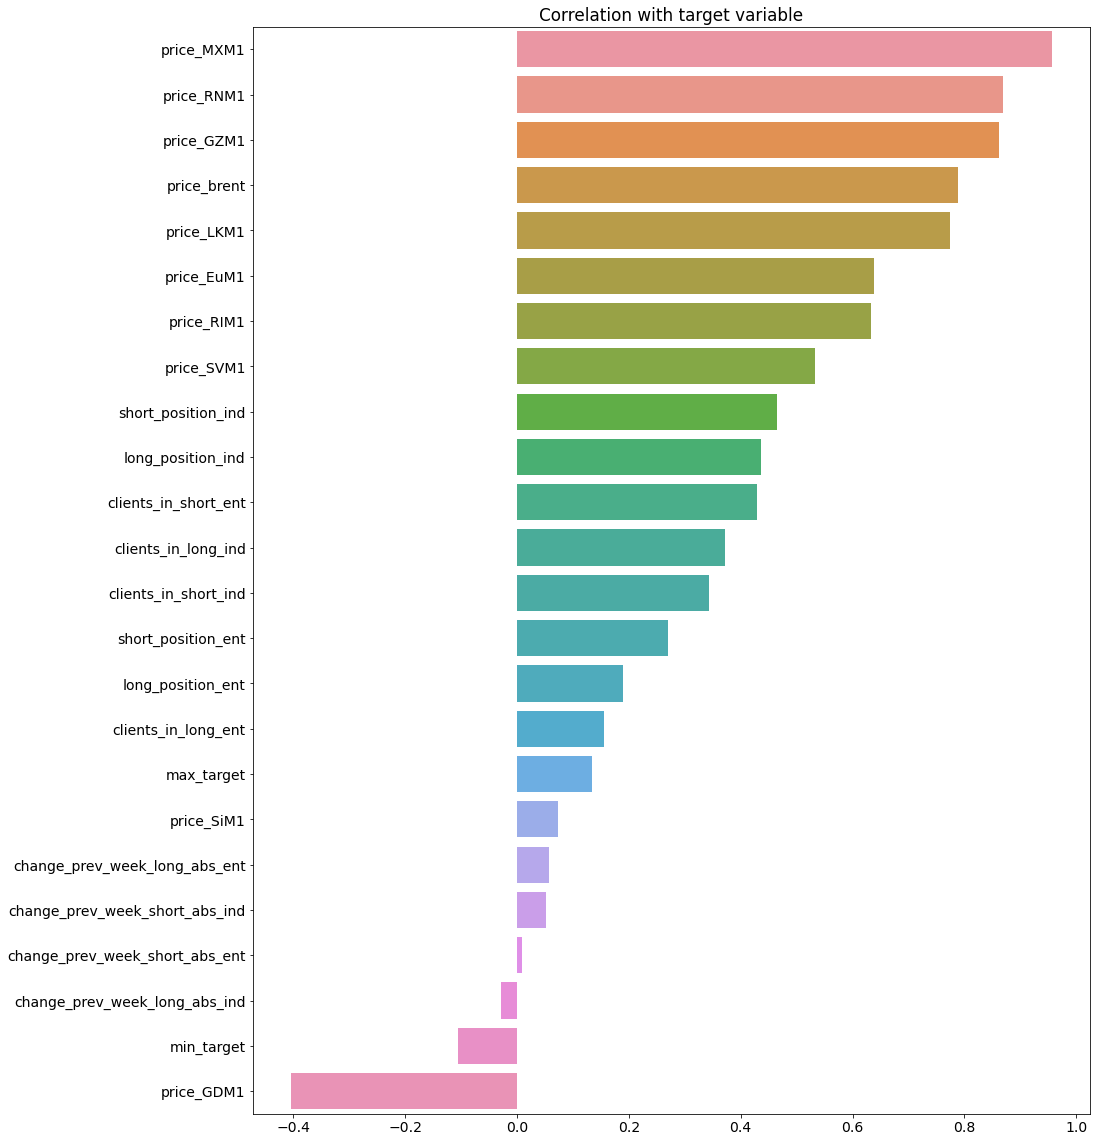

In [74]:
TARGET_NAME = 'target'

corr_with_target = derivatives.corr()[TARGET_NAME].sort_values(ascending=False)[1:]

plt.figure(figsize=(15, 20))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

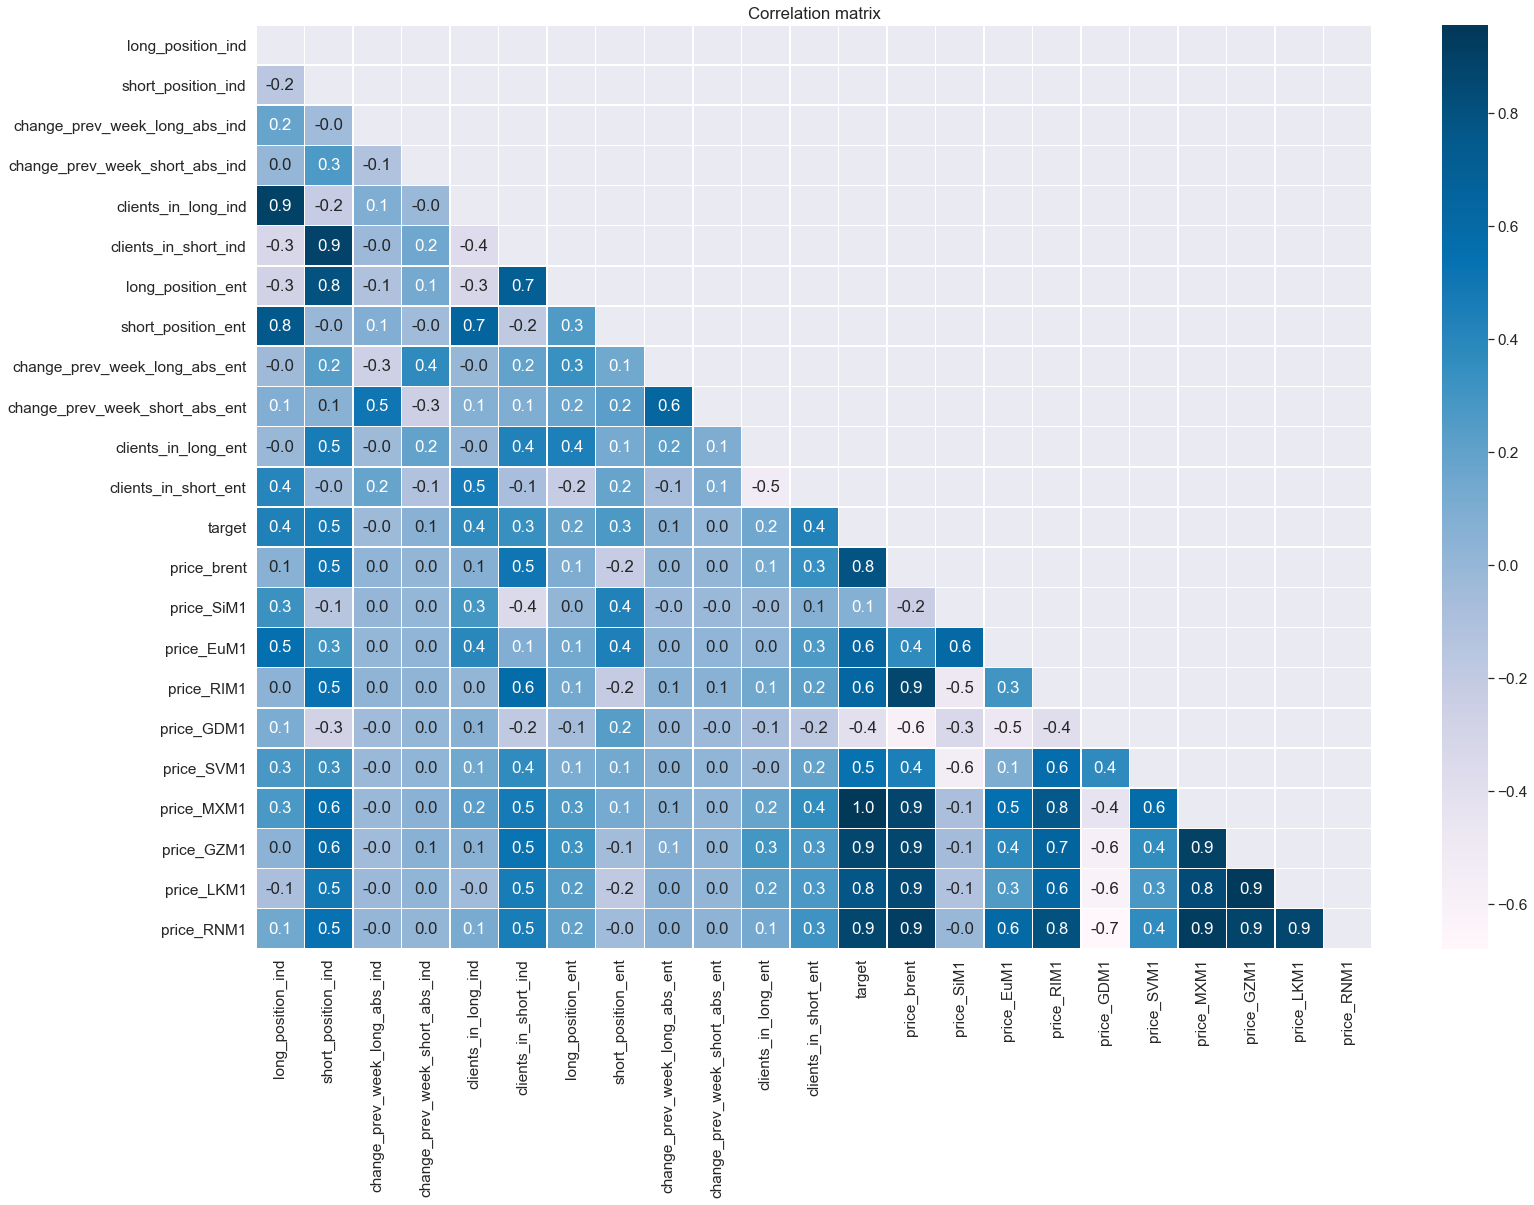

In [75]:
# df_num_features = pd.get_dummies(train_df)
df_num_features = derivatives.select_dtypes(include = ['float64', 'int64'])
num_features = pd.DataFrame(df_num_features)

corr = num_features.corr()
plt.figure(figsize = (25, 17))
mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='PuBu')
plt.title('Correlation matrix')
plt.show()

### Количественные переменные

In [76]:
derivatives.describe().T

,count,mean,std,min,25%,50%,75%,max
long_position_ind,234.00000,103466.21795,32609.43878,43971.00000,77519.25000,96159.00000,124476.75000,199025.00000
short_position_ind,234.00000,62904.27778,26098.34518,26813.00000,44714.75000,56352.00000,71362.75000,146408.00000
change_prev_week_long_abs_ind,232.00000,816.34483,13201.98793,-42033.00000,-6908.00000,790.50000,8416.75000,48738.00000
change_prev_week_short_abs_ind,232.00000,354.07328,9937.69402,-26896.00000,-4892.75000,-230.50000,4115.50000,36891.00000
clients_in_long_ind,234.00000,2695.50000,557.89737,1641.00000,2283.25000,2566.00000,3112.25000,4045.00000
clients_in_short_ind,234.00000,2355.05128,621.71089,1183.00000,1882.25000,2300.50000,2654.25000,3980.00000
long_position_ent,234.00000,63801.02137,38666.67781,33042.00000,39754.25000,50021.50000,63711.75000,203254.00000
short_position_ent,234.00000,104362.96154,34830.87643,23808.00000,78946.00000,96297.00000,128030.25000,213544.00000
change_prev_week_long_abs_ent,232.00000,1318.63362,21432.29447,-140175.00000,-3948.00000,474.00000,3863.00000,163786.00000
change_prev_week_short_abs_ent,232.00000,1523.58621,20244.49501,-121800.00000,-5112.75000,42.00000,7038.00000,122435.00000


### Категориальные переменные

In [77]:
# derivatives.describe(include=['O']).T

In [78]:
# cat_colnames = derivatives.select_dtypes(include='object').columns.tolist()
# cat_colnames

In [79]:
# for cat_colname in cat_colnames[0:]:
#     print(str(cat_colname) + '\n\n' + str(derivatives[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

###  Обработка выбросов и пропусков

In [80]:
derivatives.isnull().sum()

moment                            0
isin                              0
name                              0
long_position_ind                 0
short_position_ind                0
change_prev_week_long_abs_ind     2
change_prev_week_short_abs_ind    2
clients_in_long_ind               0
clients_in_short_ind              0
long_position_ent                 0
short_position_ent                0
change_prev_week_long_abs_ent     2
change_prev_week_short_abs_ent    2
clients_in_long_ent               0
clients_in_short_ent              0
target                            0
max_target                        0
min_target                        0
price_brent                       0
price_SiM1                        0
price_EuM1                        0
price_RIM1                        0
price_GDM1                        0
price_SVM1                        0
price_MXM1                        0
price_GZM1                        0
price_LKM1                        0
price_RNM1                  

### Целевая переменная

In [81]:
derivatives['target'].value_counts()

28081.00000    4
22000.00000    2
27389.00000    2
27342.00000    2
21600.00000    2
27910.00000    1
22456.00000    1
22596.00000    1
27728.00000    1
22583.00000    1
21418.00000    1
21163.00000    1
20863.00000    1
19756.00000    1
27818.00000    1
22016.00000    1
21900.00000    1
27108.00000    1
27680.00000    1
28142.00000    1
27006.00000    1
21505.00000    1
21189.00000    1
28306.00000    1
28005.00000    1
21222.00000    1
22448.00000    1
23200.00000    1
27506.00000    1
26506.00000    1
27240.00000    1
27413.00000    1
27380.00000    1
19684.00000    1
21045.00000    1
27642.00000    1
22516.00000    1
29122.00000    1
23374.00000    1
21887.00000    1
27353.00000    1
28500.00000    1
26370.00000    1
25181.00000    1
28166.00000    1
20200.00000    1
22545.00000    1
26996.00000    1
22400.00000    1
26705.00000    1
21623.00000    1
21715.00000    1
25768.00000    1
20800.00000    1
25610.00000    1
21943.00000    1
28252.00000    1
26488.00000    1
27928.00000   

In [82]:
derivatives['target'].describe()

count     234.00000
mean    24578.05983
std      3032.04688
min     19684.00000
25%     21629.00000
50%     24618.00000
75%     27388.00000
max     30750.00000
Name: target, dtype: float64

###  Срочный рынок, основные фьючерсные контракты

In [83]:
derivatives['target'].iat[-1]

30750.0

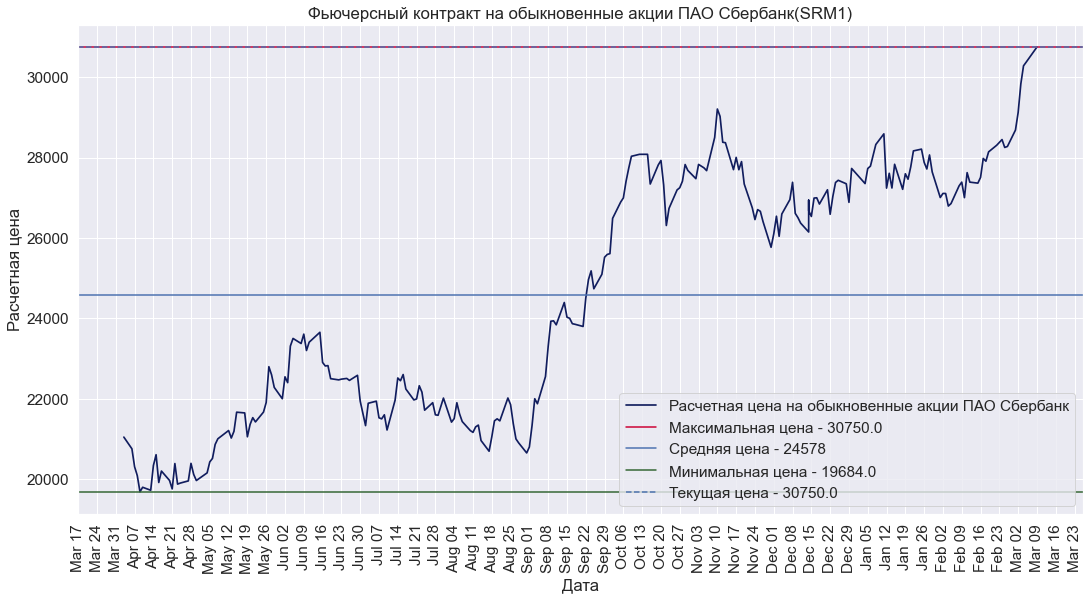

In [84]:
fig, ax = plt.subplots(figsize=(18, 9))
plt.plot(derivatives['moment'], derivatives['target'], color='#111d5e', label='Расчетная цена на обыкновенные акции ПАО Сбербанк', linewidth=1.7)
plt.axhline(y=np.nanmax(derivatives['target']), label='Максимальная цена - '+str(np.nanmax(derivatives['target'])), linestyle='-', color='#CC0033')
plt.axhline(y=np.mean(derivatives['target']), label='Средняя цена - '+str(round(np.mean(derivatives['target']))), linestyle='-')
plt.axhline(y=np.nanmin(derivatives['target']), label='Минимальная цена - '+str(np.nanmin(derivatives['target'])), linestyle='-', color='#336633')
plt.axhline(y=derivatives['target'].iat[-1], label='Текущая цена - '+str(derivatives['target'].iat[-1]), linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Расчетная цена')
plt.title('Фьючерсный контракт на обыкновенные акции ПАО Сбербанк(SRM1)')
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=90)
plt.legend()
plt.show()

fig.savefig('./graphics/SBRF.png')

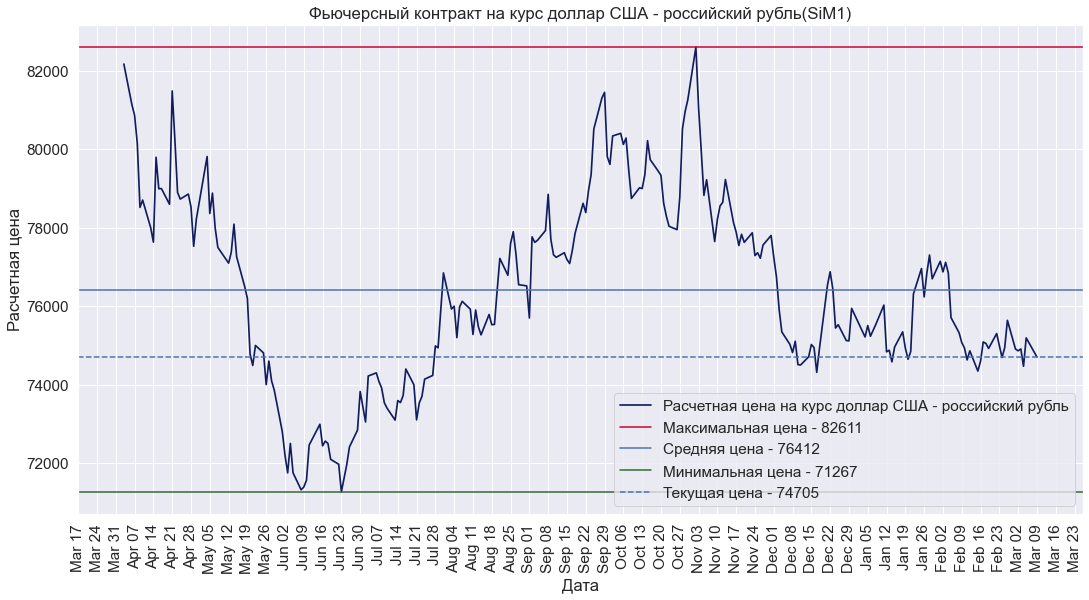

In [85]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(derivatives['moment'], derivatives['price_SiM1'], label='Расчетная цена на курс доллар США - российский рубль', color='#111d5e', linewidth=1.7)
plt.axhline(y=np.nanmax(derivatives['price_SiM1']), label='Максимальная цена - '+str(np.nanmax(derivatives['price_SiM1'])), linestyle='-', color='#CC0033')
plt.axhline(y=np.mean(derivatives['price_SiM1']), label='Средняя цена - '+str(round(np.mean(derivatives['price_SiM1']))), linestyle='-')
plt.axhline(y=np.nanmin(derivatives['price_SiM1']), label='Минимальная цена - '+str(np.nanmin(derivatives['price_SiM1'])), linestyle='-', color='#336633')
plt.axhline(y=derivatives['price_SiM1'].iat[-1], label='Текущая цена - '+str(derivatives['price_SiM1'].iat[-1]), linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Расчетная цена')
plt.title('Фьючерсный контракт на курс доллар США - российский рубль(SiM1)')
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=90)
plt.legend()
plt.show()

fig.savefig('./graphics/Si.png')

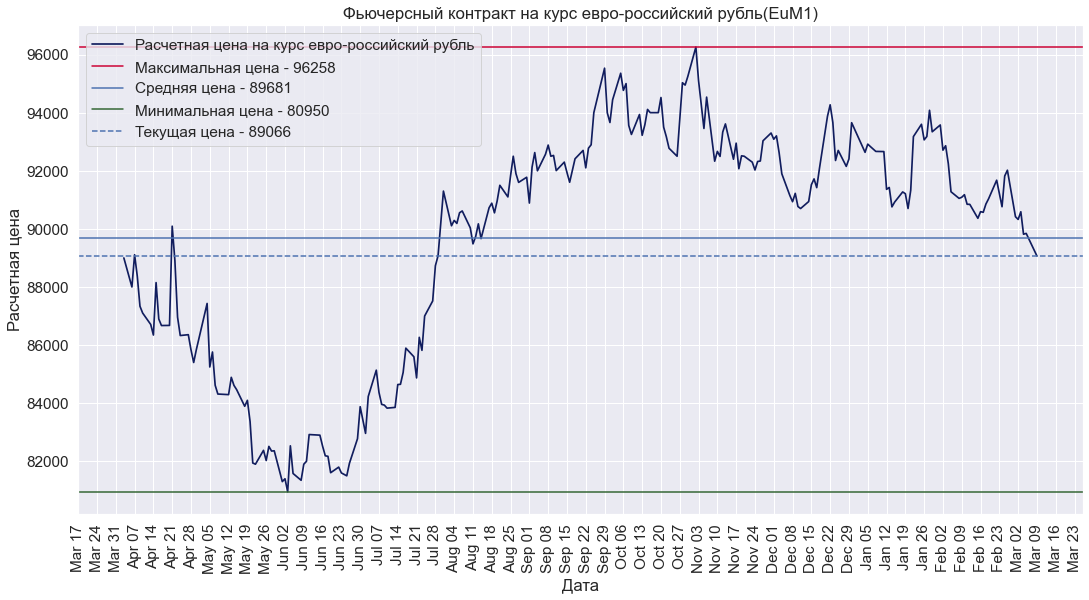

In [86]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(derivatives['moment'], derivatives['price_EuM1'], label='Расчетная цена на курс евро-российский рубль', color='#111d5e', linewidth=1.7)
plt.axhline(y=np.nanmax(derivatives['price_EuM1']), label='Максимальная цена - '+str(np.nanmax(derivatives['price_EuM1'])), linestyle='-', color='#CC0033')
plt.axhline(y=np.mean(derivatives['price_EuM1']), label='Средняя цена - '+str(round(np.mean(derivatives['price_EuM1']))), linestyle='-')
plt.axhline(y=np.nanmin(derivatives['price_EuM1']), label='Минимальная цена - '+str(np.nanmin(derivatives['price_EuM1'])), linestyle='-', color='#336633')
plt.axhline(y=derivatives['price_EuM1'].iat[-1], label='Текущая цена - '+str(derivatives['price_EuM1'].iat[-1]), linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Расчетная цена')
plt.title('Фьючерсный контракт на курс евро-российский рубль(EuM1)')
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=90)
plt.legend()
plt.show()

fig.savefig('./graphics/Eu.png')

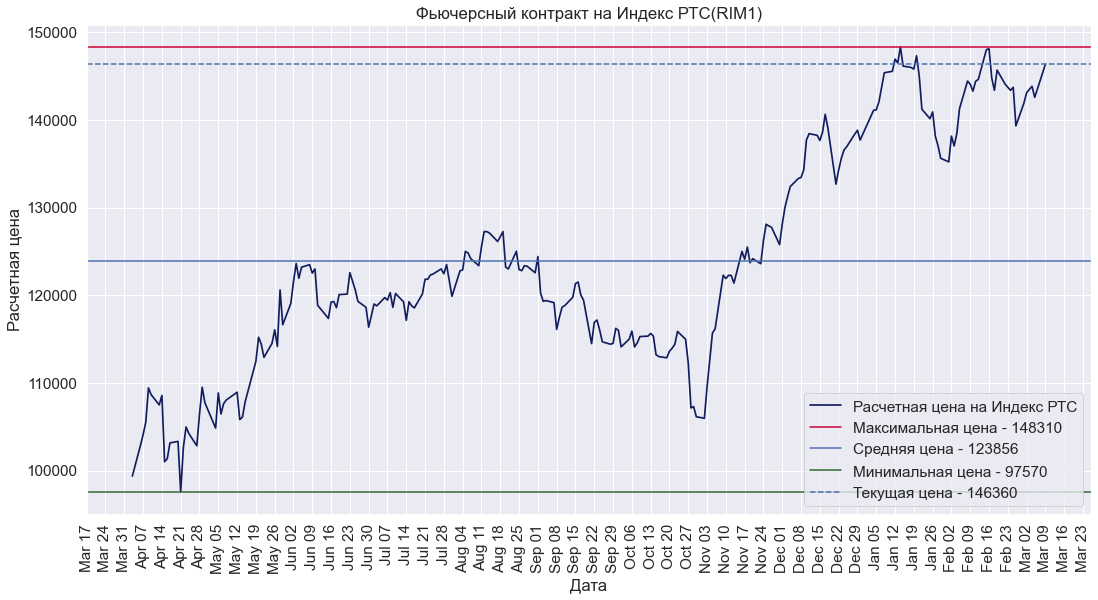

In [87]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(derivatives['moment'], derivatives['price_RIM1'], label='Расчетная цена на Индекс РТС', color='#111d5e', linewidth=1.7)
plt.axhline(y=np.nanmax(derivatives['price_RIM1']), label='Максимальная цена - '+str(np.nanmax(derivatives['price_RIM1'])), linestyle='-', color='#CC0033')
plt.axhline(y=np.mean(derivatives['price_RIM1']), label='Средняя цена - '+str(round(np.mean(derivatives['price_RIM1']))), linestyle='-')
plt.axhline(y=np.nanmin(derivatives['price_RIM1']), label='Минимальная цена - '+str(np.nanmin(derivatives['price_RIM1'])), linestyle='-', color='#336633')
plt.axhline(y=derivatives['price_RIM1'].iat[-1], label='Текущая цена - '+str(derivatives['price_RIM1'].iat[-1]), linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Расчетная цена')
plt.title('Фьючерсный контракт на Индекс РТС(RIM1)')
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=90)
plt.legend()
plt.show()

fig.savefig('./graphics/RTS.png')

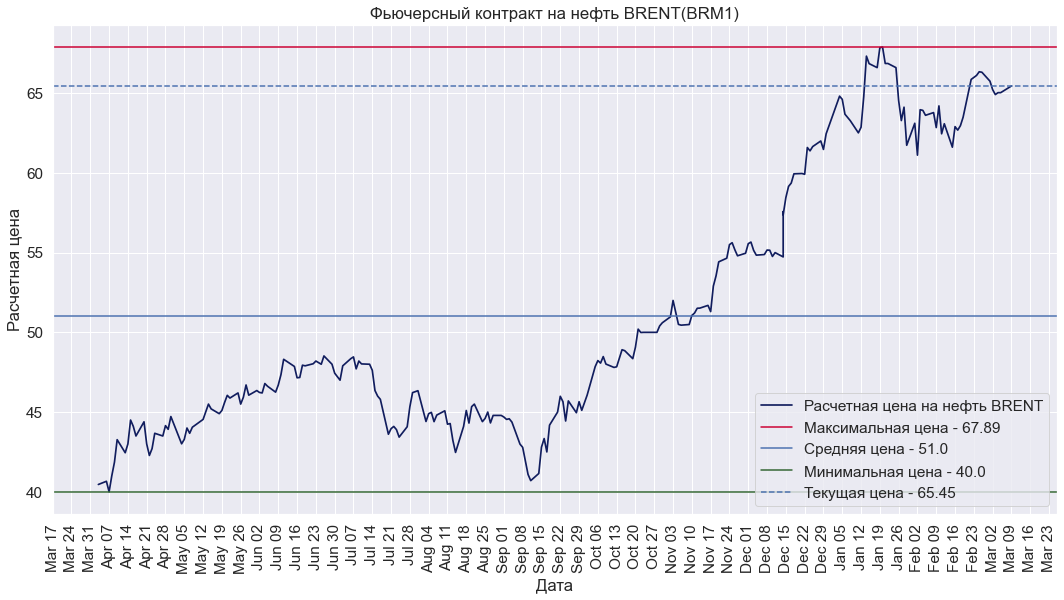

In [88]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(derivatives['moment'], derivatives['price_brent'], label='Расчетная цена на нефть BRENT', color='#111d5e', linewidth=1.7)
plt.axhline(y=np.nanmax(derivatives['price_brent']), label='Максимальная цена - '+str(np.nanmax(derivatives['price_brent'])), linestyle='-', color='#CC0033')
plt.axhline(y=np.mean(derivatives['price_brent']), label='Средняя цена - '+str(round(np.mean(derivatives['price_brent']), 1)), linestyle='-')
plt.axhline(y=np.nanmin(derivatives['price_brent']), label='Минимальная цена - '+str(np.nanmin(derivatives['price_brent'])), linestyle='-', color='#336633')
plt.axhline(y=derivatives['price_brent'].iat[-1], label='Текущая цена - '+str(derivatives['price_brent'].iat[-1]), linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Расчетная цена')
plt.title('Фьючерсный контракт на нефть BRENT(BRM1)')
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=90)
plt.legend()
plt.show()

fig.savefig('./graphics/Brent.png')

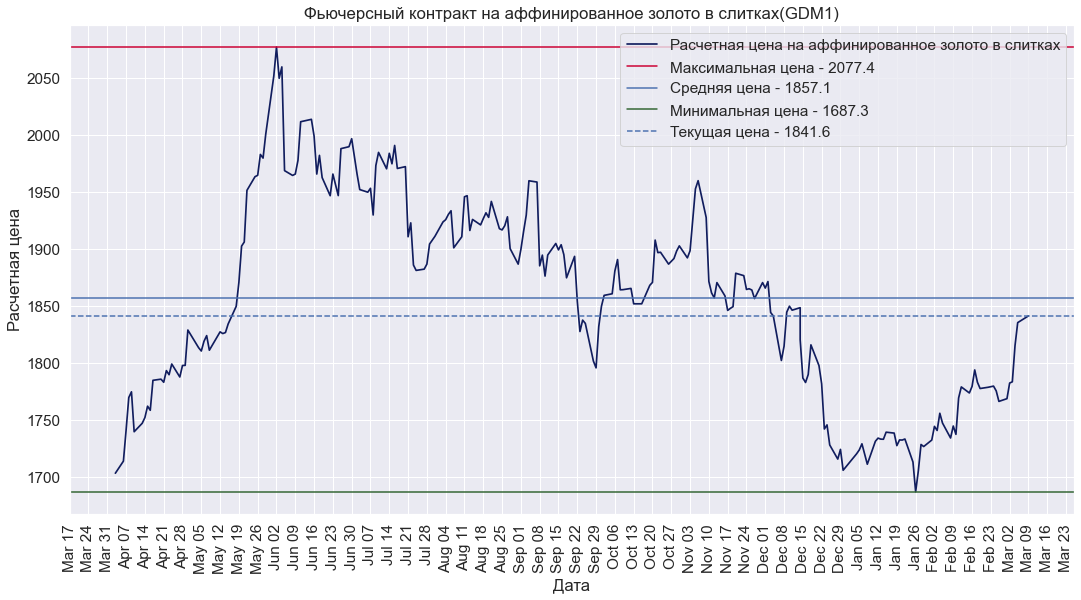

In [89]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(derivatives['moment'], derivatives['price_GDM1'], label='Расчетная цена на аффинированное золото в слитках', color='#111d5e', linewidth=1.7)
plt.axhline(y=np.nanmax(derivatives['price_GDM1']), label='Максимальная цена - '+str(np.nanmax(derivatives['price_GDM1'])), linestyle='-', color='#CC0033')
plt.axhline(y=np.mean(derivatives['price_GDM1']), label='Средняя цена - '+str(round(np.mean(derivatives['price_GDM1']), 1)), linestyle='-')
plt.axhline(y=np.nanmin(derivatives['price_GDM1']), label='Минимальная цена - '+str(np.nanmin(derivatives['price_GDM1'])), linestyle='-', color='#336633')
plt.axhline(y=derivatives['price_GDM1'].iat[-1], label='Текущая цена - '+str(derivatives['price_GDM1'].iat[-1]), linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Расчетная цена')
plt.title('Фьючерсный контракт на аффинированное золото в слитках(GDM1)')
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=90)
plt.legend()
plt.show()

fig.savefig('./graphics/GOLD.png')

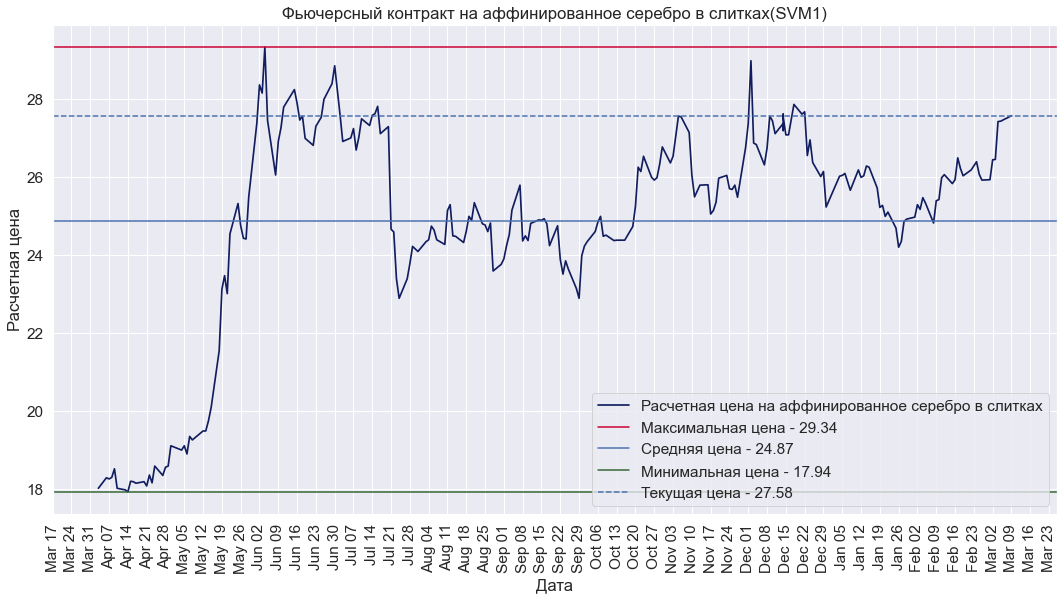

In [90]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(derivatives['moment'], derivatives['price_SVM1'], label='Расчетная цена на аффинированное серебро в слитках', color='#111d5e', linewidth=1.7)
plt.axhline(y=np.nanmax(derivatives['price_SVM1']), label='Максимальная цена - '+str(np.nanmax(derivatives['price_SVM1'])), linestyle='-', color='#CC0033')
plt.axhline(y=np.mean(derivatives['price_SVM1']), label='Средняя цена - '+str(round(np.mean(derivatives['price_SVM1']), 2)), linestyle='-')
plt.axhline(y=np.nanmin(derivatives['price_SVM1']), label='Минимальная цена - '+str(np.nanmin(derivatives['price_SVM1'])), linestyle='-', color='#336633')
plt.axhline(y=derivatives['price_SVM1'].iat[-1], label='Текущая цена - '+str(derivatives['price_SVM1'].iat[-1]), linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Расчетная цена')
plt.title('Фьючерсный контракт на аффинированное серебро в слитках(SVM1)')
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=90)
plt.legend()
plt.show()

fig.savefig('./graphics/SILV.png')

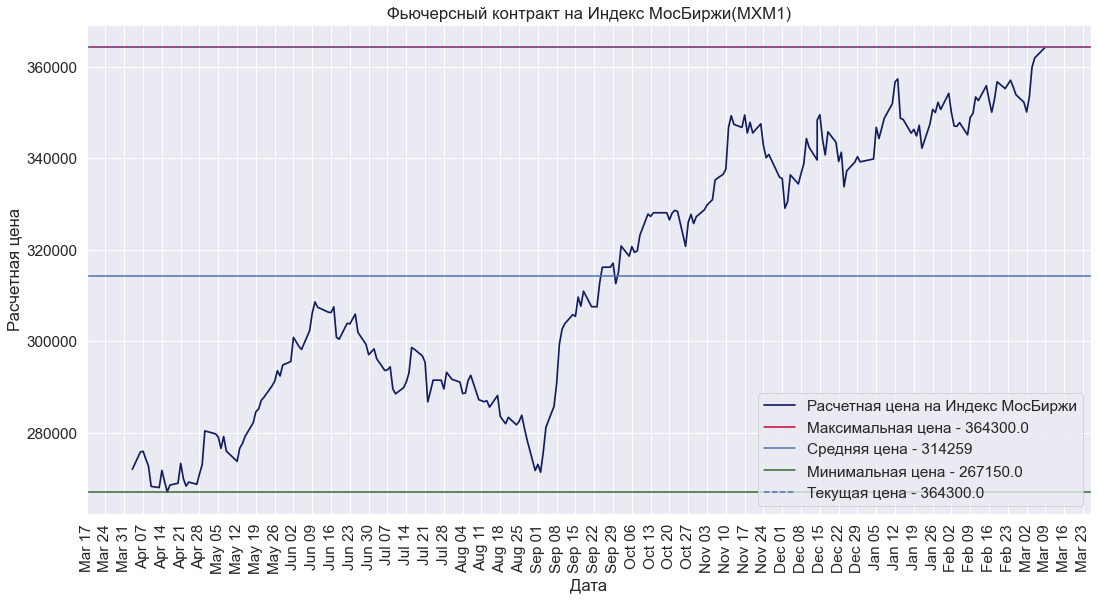

In [91]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(derivatives['moment'], derivatives['price_MXM1'], label='Расчетная цена на Индекс МосБиржи', color='#111d5e', linewidth=1.7)
plt.axhline(y=np.nanmax(derivatives['price_MXM1']), label='Максимальная цена - '+str(np.nanmax(derivatives['price_MXM1'])), linestyle='-', color='#CC0033')
plt.axhline(y=np.mean(derivatives['price_MXM1']), label='Средняя цена - '+str(round(np.mean(derivatives['price_MXM1']))), linestyle='-')
plt.axhline(y=np.nanmin(derivatives['price_MXM1']), label='Минимальная цена - '+str(np.nanmin(derivatives['price_MXM1'])), linestyle='-', color='#336633')
plt.axhline(y=derivatives['price_MXM1'].iat[-1], label='Текущая цена - '+str(derivatives['price_MXM1'].iat[-1]), linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Расчетная цена')
plt.title('Фьючерсный контракт на Индекс МосБиржи(MXM1)')
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=90)
plt.legend()
plt.show()

fig.savefig('./graphics/MIX.png')

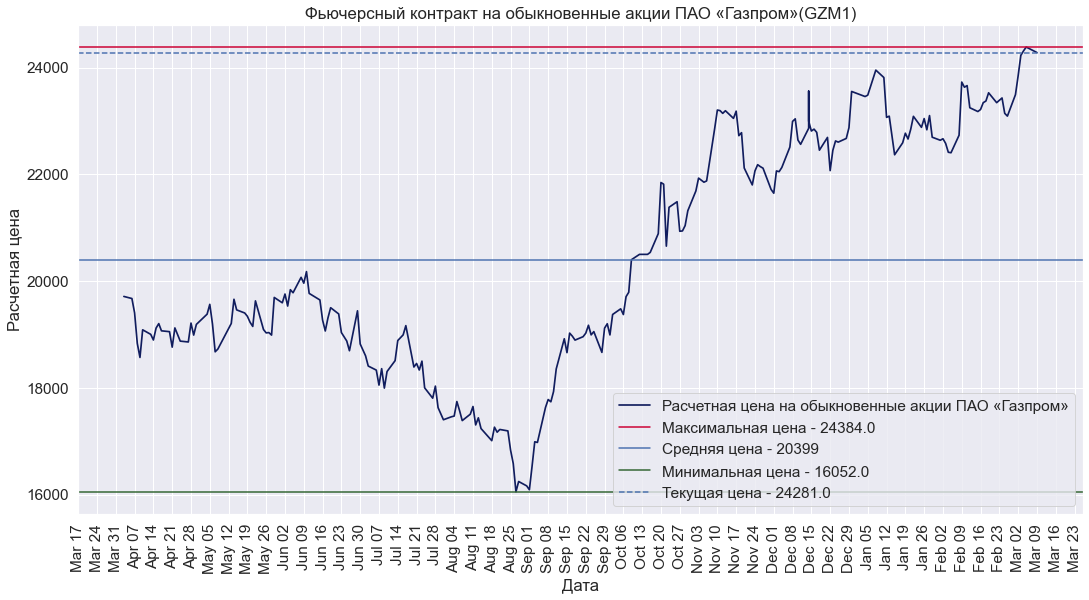

In [92]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(derivatives['moment'], derivatives['price_GZM1'], label='Расчетная цена на обыкновенные акции ПАО «Газпром»', color='#111d5e', linewidth=1.7)
plt.axhline(y=np.nanmax(derivatives['price_GZM1']), label='Максимальная цена - '+str(np.nanmax(derivatives['price_GZM1'])), linestyle='-', color='#CC0033')
plt.axhline(y=np.mean(derivatives['price_GZM1']), label='Средняя цена - '+str(round(np.mean(derivatives['price_GZM1']))), linestyle='-')
plt.axhline(y=np.nanmin(derivatives['price_GZM1']), label='Минимальная цена - '+str(np.nanmin(derivatives['price_GZM1'])), linestyle='-', color='#336633')
plt.axhline(y=derivatives['price_GZM1'].iat[-1], label='Текущая цена - '+str(derivatives['price_GZM1'].iat[-1]), linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Расчетная цена')
plt.title('Фьючерсный контракт на обыкновенные акции ПАО «Газпром»(GZM1)')
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=90)
plt.legend()
plt.show()

fig.savefig('./graphics/GAZR.png')

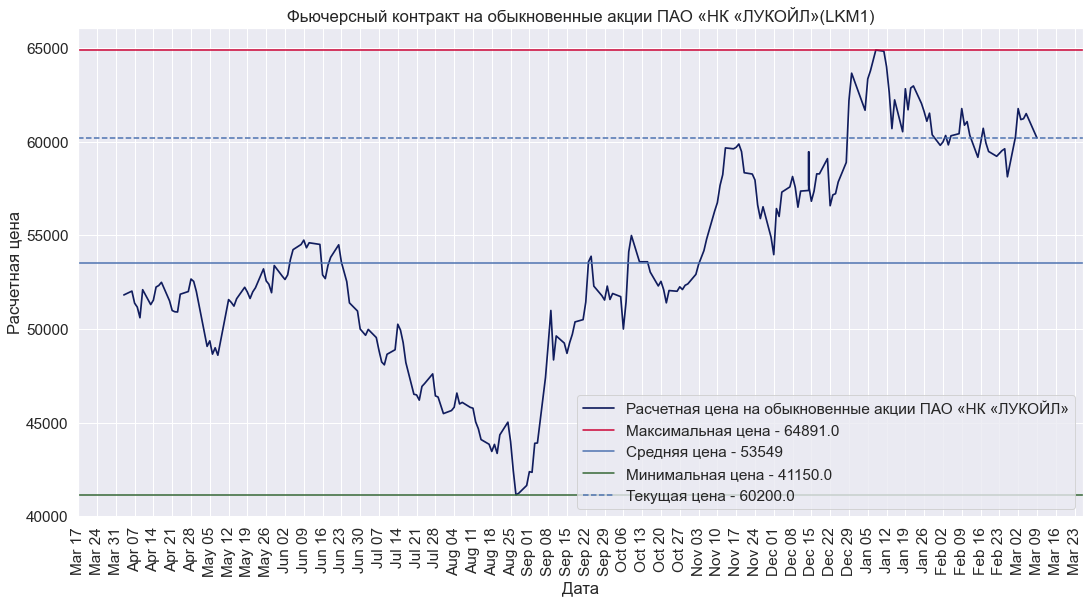

In [93]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(derivatives['moment'], derivatives['price_LKM1'], label='Расчетная цена на обыкновенные акции ПАО «НК «ЛУКОЙЛ»', color='#111d5e', linewidth=1.7)
plt.axhline(y=np.nanmax(derivatives['price_LKM1']), label='Максимальная цена - '+str(np.nanmax(derivatives['price_LKM1'])), linestyle='-', color='#CC0033')
plt.axhline(y=np.mean(derivatives['price_LKM1']), label='Средняя цена - '+str(round(np.mean(derivatives['price_LKM1']))), linestyle='-')
plt.axhline(y=np.nanmin(derivatives['price_LKM1']), label='Минимальная цена - '+str(np.nanmin(derivatives['price_LKM1'])), linestyle='-', color='#336633')
plt.axhline(y=derivatives['price_LKM1'].iat[-1], label='Текущая цена - '+str(derivatives['price_LKM1'].iat[-1]), linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Расчетная цена')
plt.title('Фьючерсный контракт на обыкновенные акции ПАО «НК «ЛУКОЙЛ»(LKM1)')
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=90)
plt.legend()
plt.show()

fig.savefig('./graphics/LKOH.png')

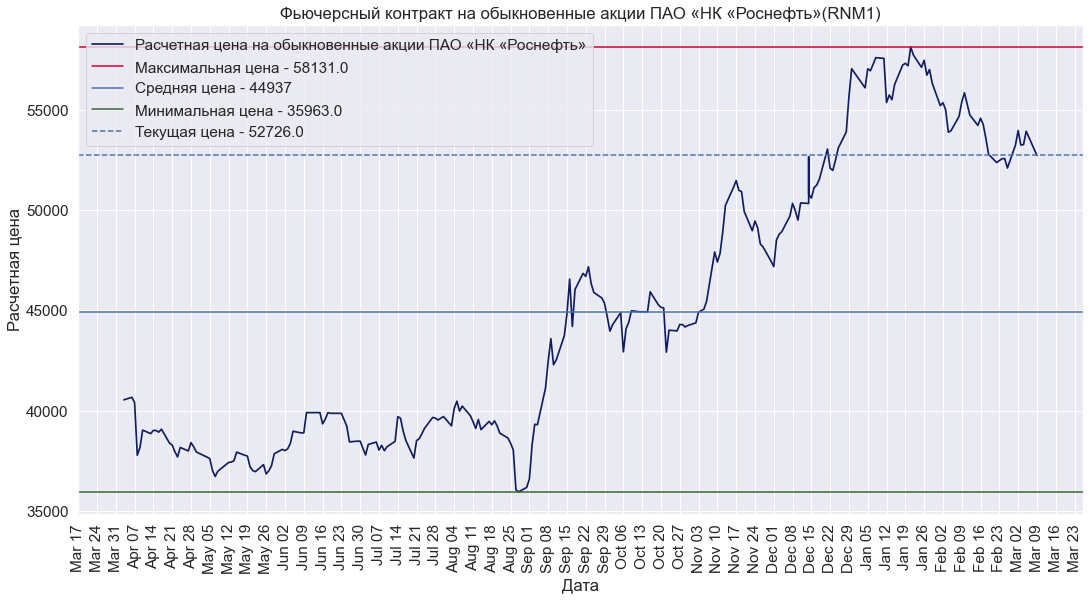

In [94]:
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(derivatives['moment'], derivatives['price_RNM1'], label='Расчетная цена на обыкновенные акции ПАО «НК «Роснефть»', color='#111d5e', linewidth=1.7)
plt.axhline(y=np.nanmax(derivatives['price_RNM1']), label='Максимальная цена - '+str(np.nanmax(derivatives['price_RNM1'])), linestyle='-', color='#CC0033')
plt.axhline(y=np.mean(derivatives['price_RNM1']), label='Средняя цена - '+str(round(np.mean(derivatives['price_RNM1']))), linestyle='-')
plt.axhline(y=np.nanmin(derivatives['price_RNM1']), label='Минимальная цена - '+str(np.nanmin(derivatives['price_RNM1'])), linestyle='-', color='#336633')
plt.axhline(y=derivatives['price_RNM1'].iat[-1], label='Текущая цена - '+str(derivatives['price_RNM1'].iat[-1]), linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Расчетная цена')
plt.title('Фьючерсный контракт на обыкновенные акции ПАО «НК «Роснефть»(RNM1)')
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=90)
plt.legend()
plt.show()

fig.savefig('./graphics/ROSN.png')

### Соотношение количества договоров (контрактов) физ./юр. лиц, фьючерсный контракт на обыкновенные акции ПАО Сбербанк(SRM1).

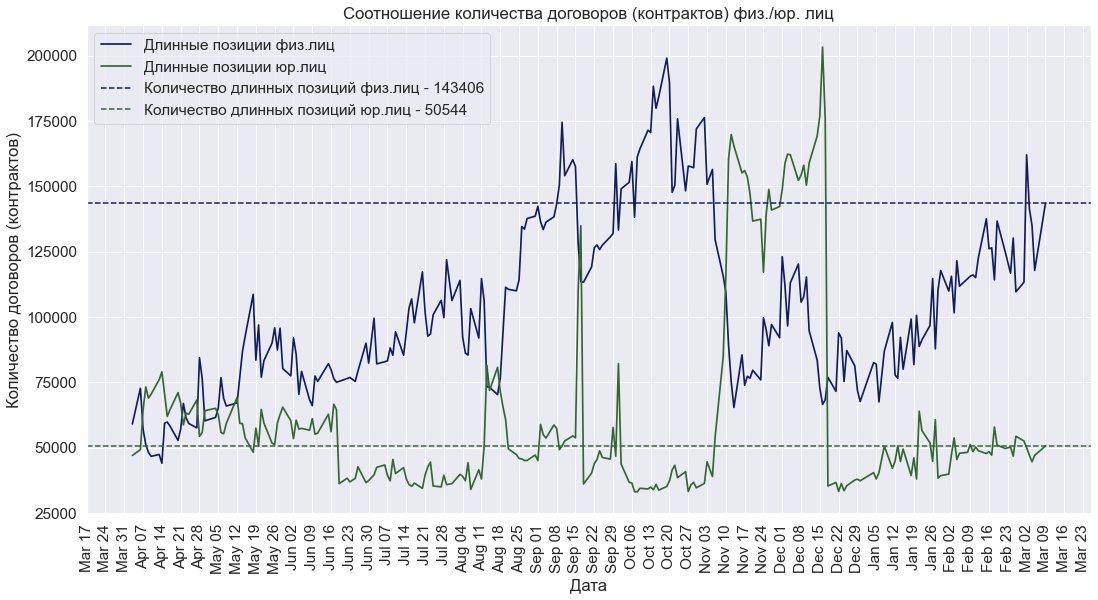

In [95]:
fig, ax = plt.subplots(figsize=(18, 9))
plt.plot(derivatives['moment'], derivatives['long_position_ind'], color='#111d5e', label='Длинные позиции физ.лиц', linewidth=1.7)
plt.plot(derivatives['moment'], derivatives['long_position_ent'], color='#336633', label='Длинные позиции юр.лиц', linewidth=1.7)
plt.axhline(y=derivatives['long_position_ind'].iat[-1], label='Количество длинных позиций физ.лиц - '+str(round(derivatives['long_position_ind'].iat[-1])), linestyle='--', color='#111d5e')
plt.axhline(y=derivatives['long_position_ent'].iat[-1], label='Количество длинных позиций юр.лиц - '+str(round(derivatives['long_position_ent'].iat[-1])), linestyle='--', color='#336633')
plt.xlabel('Дата')
plt.ylabel('Количество договоров (контрактов)')
# plt.xticks([])
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=90) 
plt.title('Соотношение количества договоров (контрактов) физ./юр. лиц')
plt.legend()
plt.show()

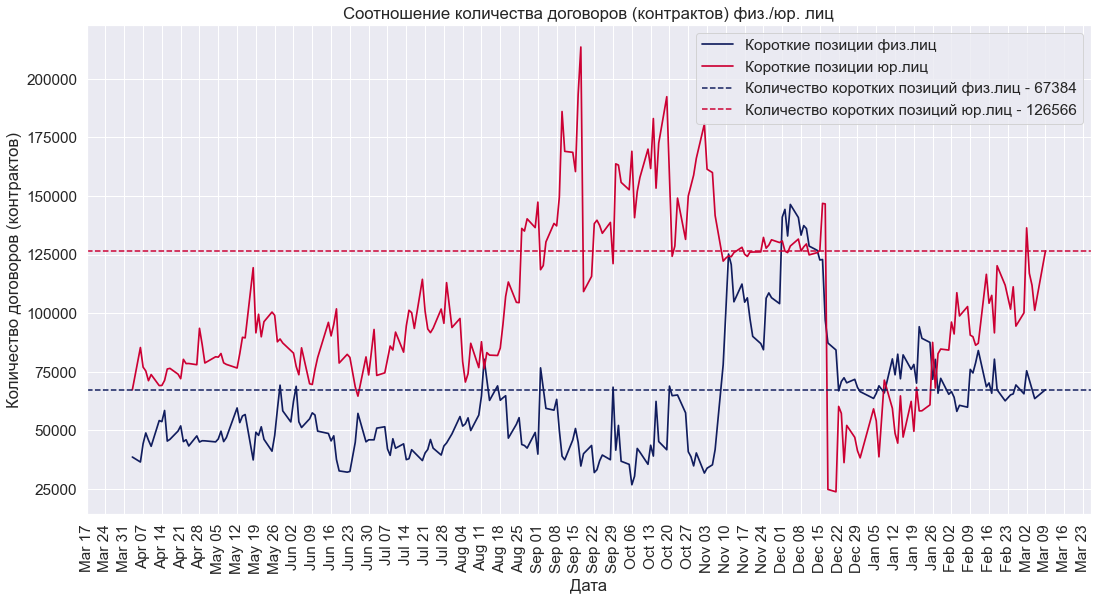

In [96]:
fig, ax = plt.subplots(figsize=(18, 9))
plt.plot(derivatives['moment'], derivatives['short_position_ind'], color='#111d5e', label='Короткие позиции физ.лиц', linewidth=1.7)
plt.plot(derivatives['moment'], derivatives['short_position_ent'], color='#CC0033', label='Короткие позиции юр.лиц', linewidth=1.7)
plt.axhline(y=derivatives['short_position_ind'].iat[-1], label='Количество коротких позиций физ.лиц - '+str(round(derivatives['short_position_ind'].iat[-1])), linestyle='--', color='#111d5e')
plt.axhline(y=derivatives['short_position_ent'].iat[-1], label='Количество коротких позиций юр.лиц - '+str(round(derivatives['short_position_ent'].iat[-1])), linestyle='--', color='#CC0033')
plt.xlabel('Дата')
plt.ylabel('Количество договоров (контрактов)')
# plt.xticks([])
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=90) 
plt.title('Соотношение количества договоров (контрактов) физ./юр. лиц')
plt.legend()
plt.show()

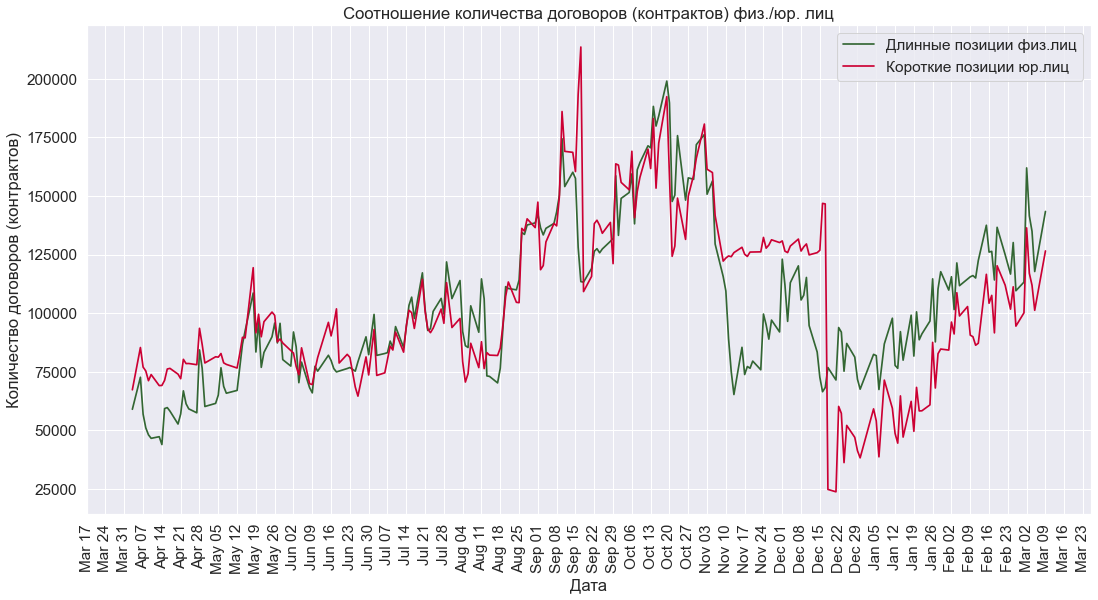

In [97]:
fig, ax = plt.subplots(figsize=(18, 9))
plt.plot(derivatives['moment'], derivatives['long_position_ind'], color='#336633', label='Длинные позиции физ.лиц', linewidth=1.7)
plt.plot(derivatives['moment'], derivatives['short_position_ent'], color='#CC0033', label='Короткие позиции юр.лиц', linewidth=1.7)
plt.xlabel('Дата')
plt.ylabel('Количество договоров (контрактов)')
# plt.xticks([])
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=90) 
plt.title('Соотношение количества договоров (контрактов) физ./юр. лиц')
plt.legend()
plt.show()

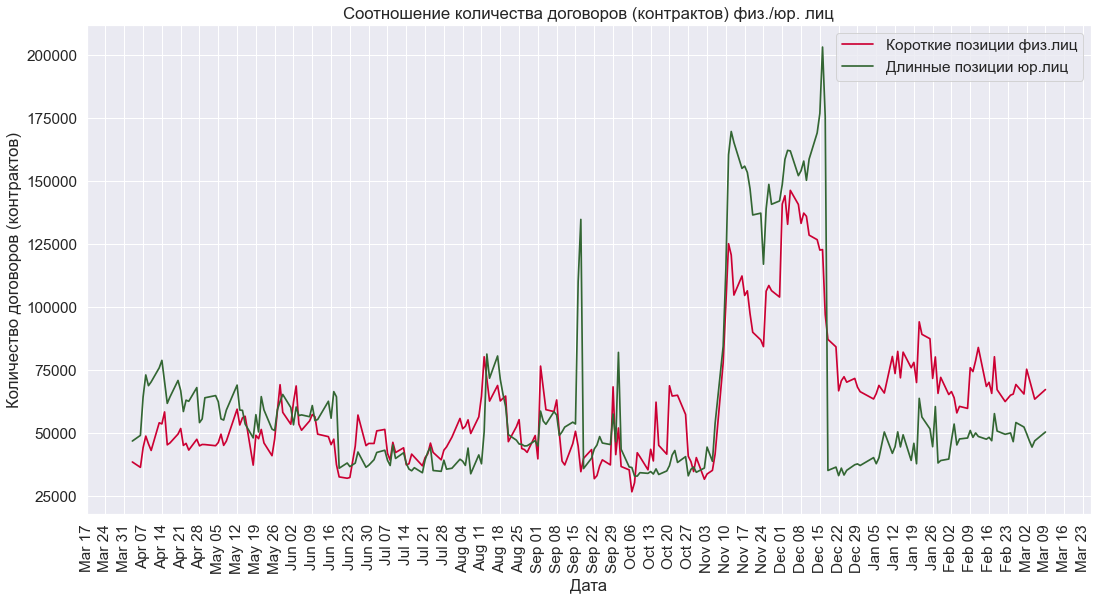

In [98]:
fig, ax = plt.subplots(figsize=(18, 9))
plt.plot(derivatives['moment'], derivatives['short_position_ind'], color='#CC0033', label='Короткие позиции физ.лиц', linewidth=1.7)
plt.plot(derivatives['moment'], derivatives['long_position_ent'], color='#336633', label='Длинные позиции юр.лиц', linewidth=1.7)
plt.xlabel('Дата')
plt.ylabel('Количество договоров (контрактов)')
# plt.xticks([])
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=90) 
plt.title('Соотношение количества договоров (контрактов) физ./юр. лиц')
plt.legend()
plt.show()

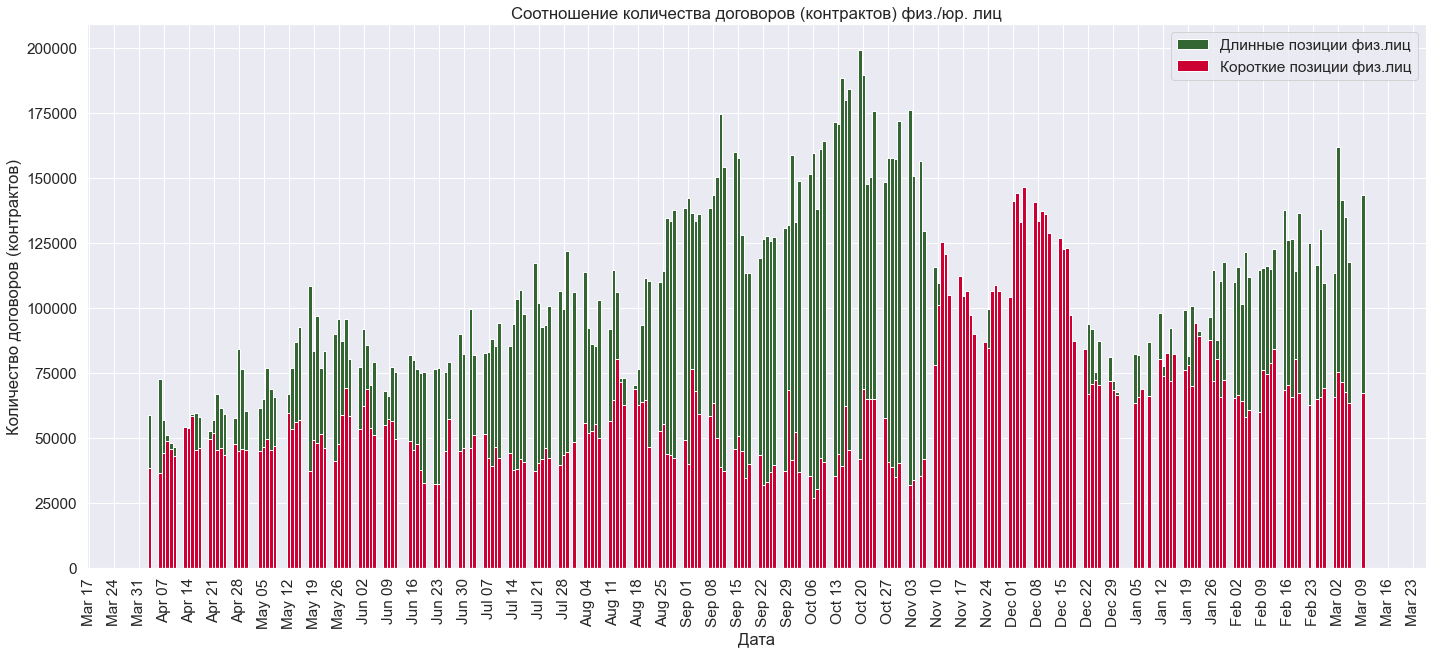

In [99]:
fig, ax = plt.subplots(figsize=(24, 10))
ax.bar(derivatives['moment'], derivatives['long_position_ind'], color='#336633', ec='white', label='Длинные позиции физ.лиц', width=1)
ax.bar(derivatives['moment'], derivatives['short_position_ind'], color='#CC0033', ec='white', label='Короткие позиции физ.лиц', width=1)
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set(xlabel='Дата',
       ylabel='Количество договоров (контрактов)',
       title='Соотношение количества договоров (контрактов) физ./юр. лиц')
plt.xticks(rotation=90)
plt.legend()
plt.show()

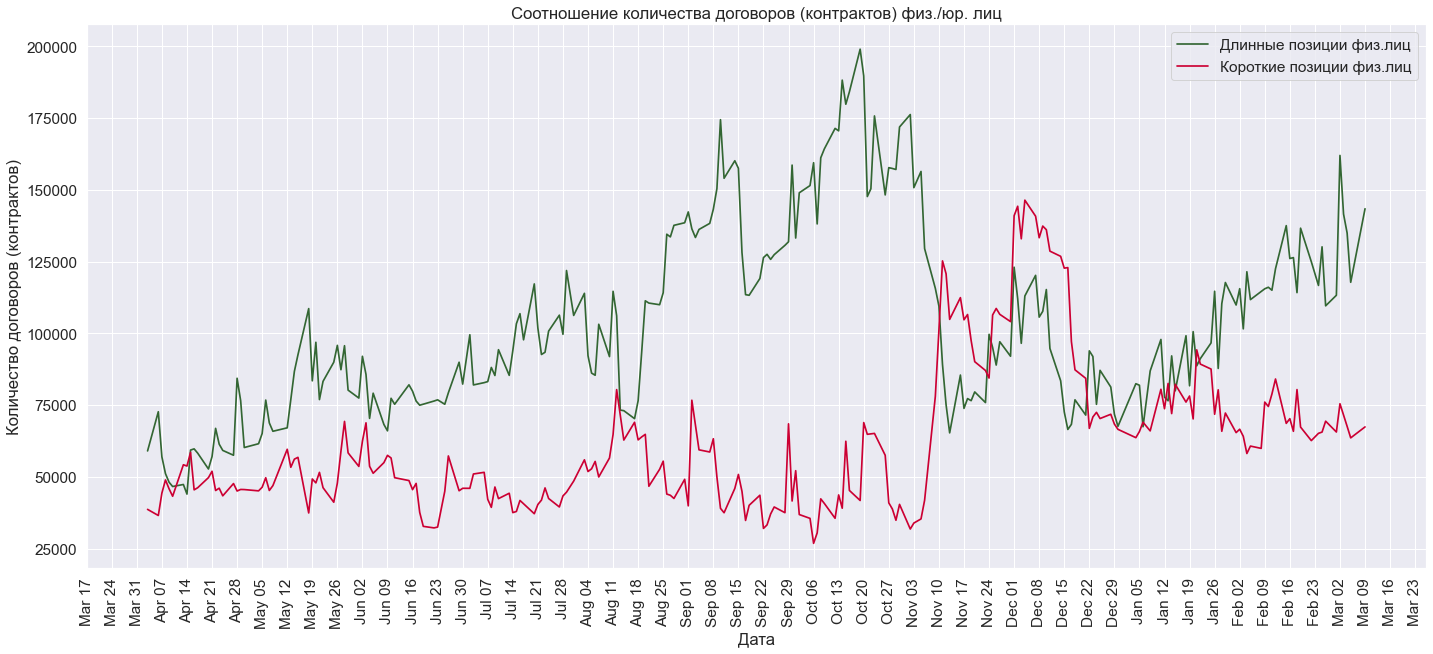

In [100]:
fig, ax = plt.subplots(figsize=(24, 10))
ax.plot(derivatives['moment'], derivatives['long_position_ind'], color='#336633', label='Длинные позиции физ.лиц', linewidth=1.7)
ax.plot(derivatives['moment'], derivatives['short_position_ind'], color='#CC0033', label='Короткие позиции физ.лиц', linewidth=1.7)
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set(xlabel='Дата',
       ylabel='Количество договоров (контрактов)',
       title='Соотношение количества договоров (контрактов) физ./юр. лиц')
plt.xticks(rotation=90)
plt.legend()
plt.show()

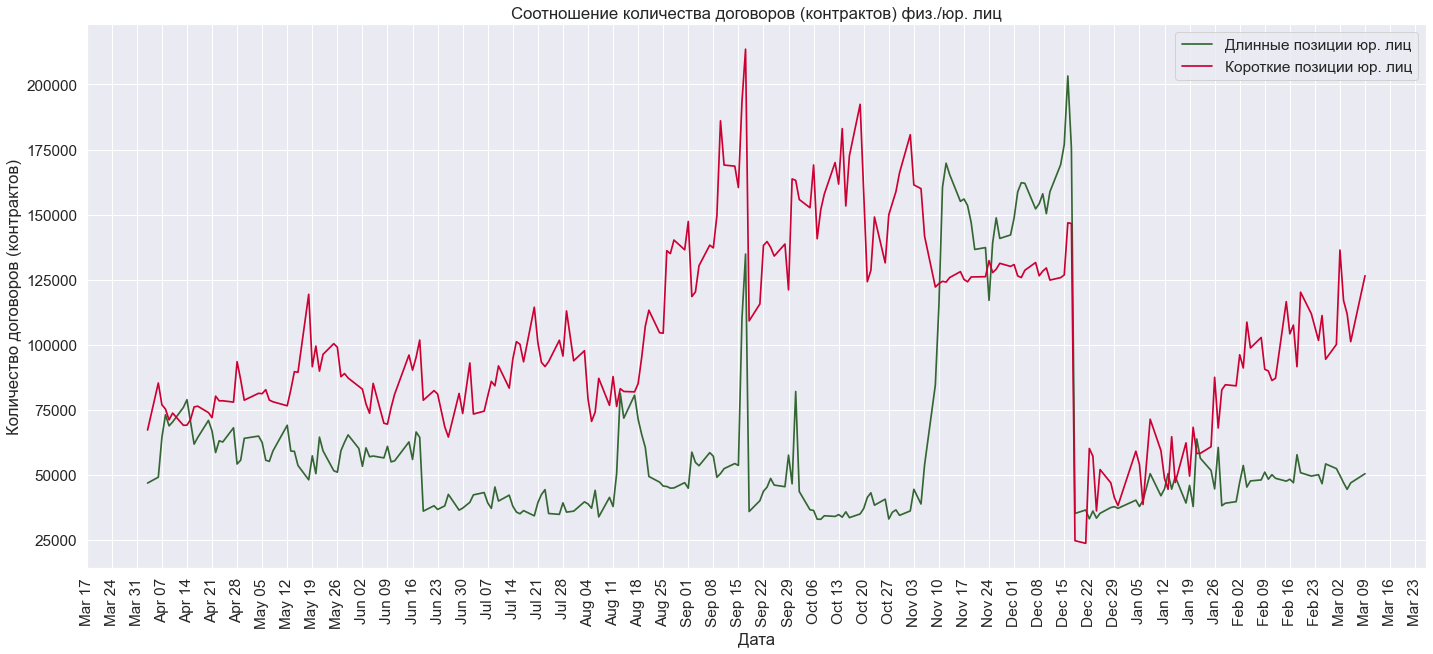

In [101]:
fig, ax = plt.subplots(figsize=(24, 10))
ax.plot(derivatives['moment'], derivatives['long_position_ent'], color='#336633', label='Длинные позиции юр. лиц', linewidth=1.7)
ax.plot(derivatives['moment'], derivatives['short_position_ent'], color='#CC0033', label='Короткие позиции юр. лиц', linewidth=1.7)
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set(xlabel='Дата',
       ylabel='Количество договоров (контрактов)',
       title='Соотношение количества договоров (контрактов) физ./юр. лиц')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Подготовка признаков

In [102]:
X = pd.get_dummies(derivatives)
X.drop('target', axis=1, inplace=True)
X.drop('moment', axis=1, inplace=True)
X.drop('change_prev_week_long_abs_ind', axis=1, inplace=True)
X.drop('change_prev_week_short_abs_ind', axis=1, inplace=True)
X.drop('change_prev_week_long_abs_ent', axis=1, inplace=True)
X.drop('change_prev_week_short_abs_ent', axis=1, inplace=True)
y = derivatives['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [103]:
models = []

models.append(('BaggingRegressor', BaggingRegressor()))
models.append(('CatBoostRegressor', CatBoostRegressor(silent=True)))
models.append(('ExtraTreesRegressor', ExtraTreesRegressor()))
models.append(('GradientBoostingRegressor', GradientBoostingRegressor()))
models.append(('RandomForestRegressor', RandomForestRegressor()))

In [104]:
results = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred_train  = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    R2 = r2_score(y_test, y_pred_test)
    MAE = mean_absolute_error(y_test, y_pred_test)
    MSE = mean_squared_error(y_test, y_pred_test)
    EV = explained_variance_score(y_test, y_pred_test)
    results.append((name, R2, EV, MAE, MSE))
    
best_models = pd.DataFrame(results, columns = ['model','R2', 'EV', 'MAE', 'MSE'])
best_models.sort_values('R2', ascending=False)

,model,R2,EV,MAE,MSE
1,CatBoostRegressor,0.98607,0.98622,251.20120,104853.03523
3,GradientBoostingRegressor,0.98562,0.98566,273.84962,108183.43227
2,ExtraTreesRegressor,0.98414,0.98421,274.14864,119389.70595
0,BaggingRegressor,0.97940,0.97948,309.55424,154994.77068
4,RandomForestRegressor,0.97884,0.97884,329.74068,159269.17903


In [105]:
%%time

model_cbr = CatBoostRegressor(silent=True, max_depth=2, n_estimators=809, random_state=57)
model_cbr.fit(X_train, y_train)
y_pred_train  = model_cbr.predict(X_train)
y_pred_test = model_cbr.predict(X_test)
print('CatBoostRegressor: r2_score - ' + str(r2_score(y_test, y_pred_test)))
print('CatBoostRegressor: MAE - ' + str(mean_absolute_error(y_test, y_pred_test)))
print('CatBoostRegressor: MSE - ' + str(mean_squared_error(y_test, y_pred_test)))

CatBoostRegressor: r2_score - 0.9825386466395998
CatBoostRegressor: MAE - 287.6684612997973
CatBoostRegressor: MSE - 131405.56201909328
Wall time: 648 ms


In [106]:
%%time

model_etr = ExtraTreesRegressor(max_depth=10, max_features='auto', n_estimators=88, random_state=34)
model_etr.fit(X_train, y_train)
y_pred_train  = model_etr.predict(X_train)
y_pred_test = model_etr.predict(X_test)
print('ExtraTreesRegressor: r2_score - ' + str(r2_score(y_test, y_pred_test)))
print('ExtraTreesRegressor: MAE - ' + str(mean_absolute_error(y_test, y_pred_test)))
print('ExtraTreesRegressor: MSE - ' + str(mean_squared_error(y_test, y_pred_test)))

ExtraTreesRegressor: r2_score - 0.9837679057873121
ExtraTreesRegressor: MAE - 284.65627260033216
ExtraTreesRegressor: MSE - 122154.76193285364
Wall time: 207 ms


In [107]:
%%time

model_gbr = GradientBoostingRegressor() # max_depth=3, n_estimators=54, random_state=45, min_samples_split=4
model_gbr.fit(X_train, y_train)
y_pred_train  = model_gbr.predict(X_train)
y_pred_test = model_gbr.predict(X_test)
print('GradientBoostingRegressor: r2_score - ' + str(r2_score(y_test, y_pred_test)))
print('GradientBoostingRegressor: MAE - ' + str(mean_absolute_error(y_test, y_pred_test)))
print('GradientBoostingRegressor: MSE - ' + str(mean_squared_error(y_test, y_pred_test)))

GradientBoostingRegressor: r2_score - 0.9850103248059147
GradientBoostingRegressor: MAE - 277.23004250224847
GradientBoostingRegressor: MSE - 112804.9271272119
Wall time: 119 ms


### Автоматический подбор параметров(GridSearchCV)

In [108]:
# estimator = GradientBoostingRegressor()
# param_grid = {
#     'n_estimators': [54],
#     'min_samples_split': [14],
#     'max_depth': [3],
#     'random_state': [45]
# }

# model_gbr = GridSearchCV(estimator, param_grid, scoring='r2')
# model_gbr.fit(X_train, y_train)

# print('Best parameters found by grid search are:', model_gbr.best_params_)

### Построение кривых обучения / Plotting Learning Curves

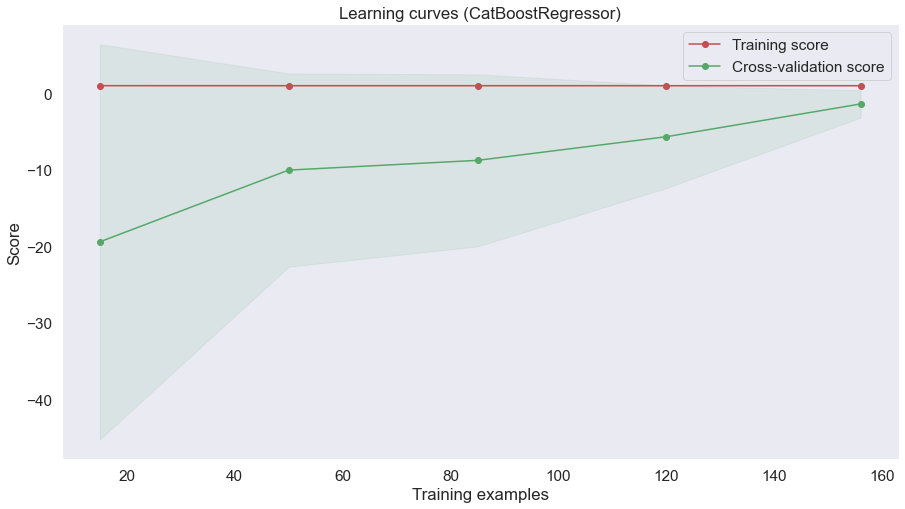

In [109]:
show_learning_curve_plot(model_cbr, X, y)

### Прогнозирование временных рядов / Time Series Forecasting as Supervised Learning

In [110]:
tsf_derivatives = pd.DataFrame()

In [111]:
tsf_derivatives['moment'] = derivatives['moment']
tsf_derivatives['target'] = derivatives['target']

In [112]:
tsf_derivatives.head()

,moment,target
0,2020-04-03,21045.00000
1,2020-04-06,20754.00000
2,2020-04-07,20306.00000
3,2020-04-08,20087.00000
4,2020-04-09,19684.00000


In [113]:
tsf_derivatives.tail()

,moment,target
229,2021-03-02,29122.00000
230,2021-03-03,29834.00000
231,2021-03-04,30283.00000
232,2021-03-05,30375.00000
233,2021-03-09,30750.00000


In [114]:
tsf_derivatives.shape

(234, 2)

In [115]:
dataset = tsf_derivatives.iloc[:,1].values

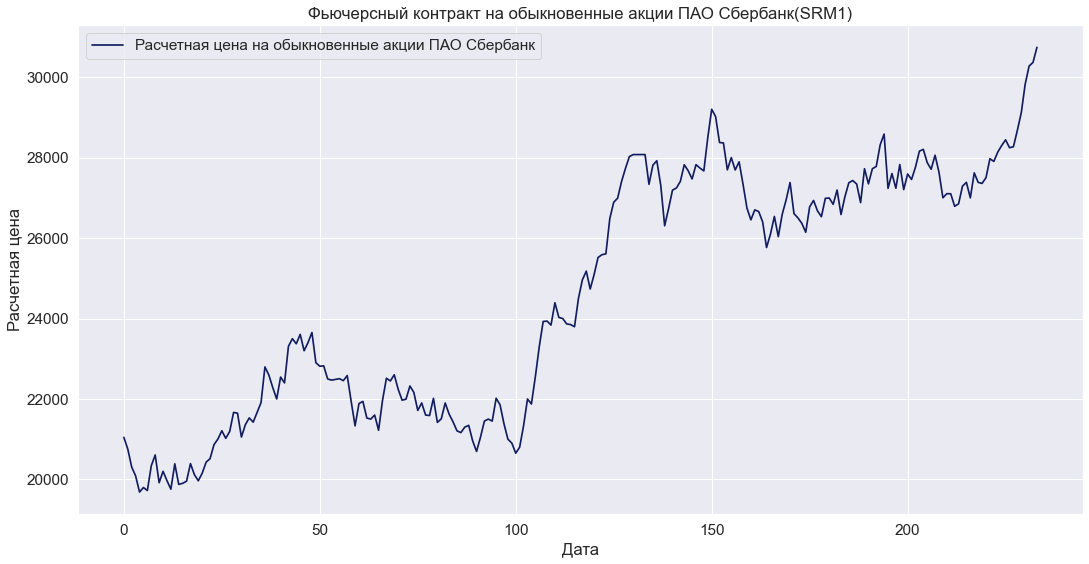

In [116]:
fig, ax = plt.subplots(figsize=(18, 9))
plt.plot(dataset, color='#111d5e', label='Расчетная цена на обыкновенные акции ПАО Сбербанк', linewidth=1.7)
plt.xlabel('Дата')
plt.ylabel('Расчетная цена')
plt.title('Фьючерсный контракт на обыкновенные акции ПАО Сбербанк(SRM1)')
# #set ticks every week
# ax.xaxis.set_major_locator(mdates.WeekdayLocator())
# #set major ticks format
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# plt.xticks(rotation=90)
plt.legend()
plt.show()

# fig.savefig('./graphics/SBRF_TSF.png')

In [117]:
# Preprocessing
dataset = dataset.reshape(-1, 1)
dataset = dataset.astype('float32')
dataset.shape

(234, 1)

### Нормализация данных
Перед обучением нейронной сети важно масштабировать функции. Нормализация - это обычный способ масштабирования.

In [118]:
# scaler = MinMaxScaler()
# dataset = scaler.fit_transform(dataset)

minmax_scaler = MinMaxScaler()
# robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

dataset = standard_scaler.fit_transform(dataset)
# dataset = robust_scaler.fit_transform(dataset)
dataset = minmax_scaler.fit_transform(dataset)

### Разделение данных
Мы будем использовать разделение (~50%) для наборов для обучения, проверки и тестирования. Обратите внимание, что данные не перемешиваются случайным образом перед разделением. Это по двум причинам.

<li>Это гарантирует, что по-прежнему возможно разделение данных на окна последовательных выборок  
<li>Это гарантирует, что результаты проверки / тестирования будут более реалистичными, поскольку будут оцениваться на основе данных, собранных после обучения модели

In [119]:
train_size = int(len(dataset)*0.51)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]
print(len(train), len(test))

119 115


In [120]:
# X_train, X_test, y_train, y_test = train_test_split(X, y)
time_temp = 7
X_temp = []
Y_temp = []
for i in range(len(train)-time_temp-1):
    a = train[i:(i+time_temp), 0]
    X_temp.append(a)
    Y_temp.append(train[i + time_temp, 0])
X_train = np.array(X_temp)
y_train = np.array(Y_temp) 

In [121]:
ast = len(train)
act = ast-time_temp-1
aaa = train[i, 0]
print(ast, act, aaa)

119 111 0.42562807


In [122]:
X_temp = []
Y_temp = []
for i in range(len(test)-time_temp-1):
    a = test[i:(i+time_temp), 0]
    X_temp.append(a)
    Y_temp.append(test[i + time_temp, 0])
X_test = np.array(X_temp)
y_test = np.array(Y_temp) 

In [123]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [124]:
model = Sequential([
    LSTM(15, input_shape=(1, time_temp)),
    Dense(1)
])

In [125]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [126]:
%%time
model.fit(X_train, y_train, epochs=50, batch_size=1)

Epoch 1/50
111/111 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 2/50
111/111 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 3/50
111/111 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 4/50
111/111 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 5/50
111/111 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 6/50
111/111 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 7/50
111/111 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 8/50
111/111 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 9/50
111/111 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 10/50
111/111 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 11/50
111/111 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 12/50
111/111 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 13/50
111/111 [====

In [127]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = minmax_scaler.inverse_transform(trainPredict)
y_train = minmax_scaler.inverse_transform([y_train])
testPredict = minmax_scaler.inverse_transform(testPredict)
y_test = minmax_scaler.inverse_transform([y_test])

trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.12 RMSE
Test Score: 0.16 RMSE


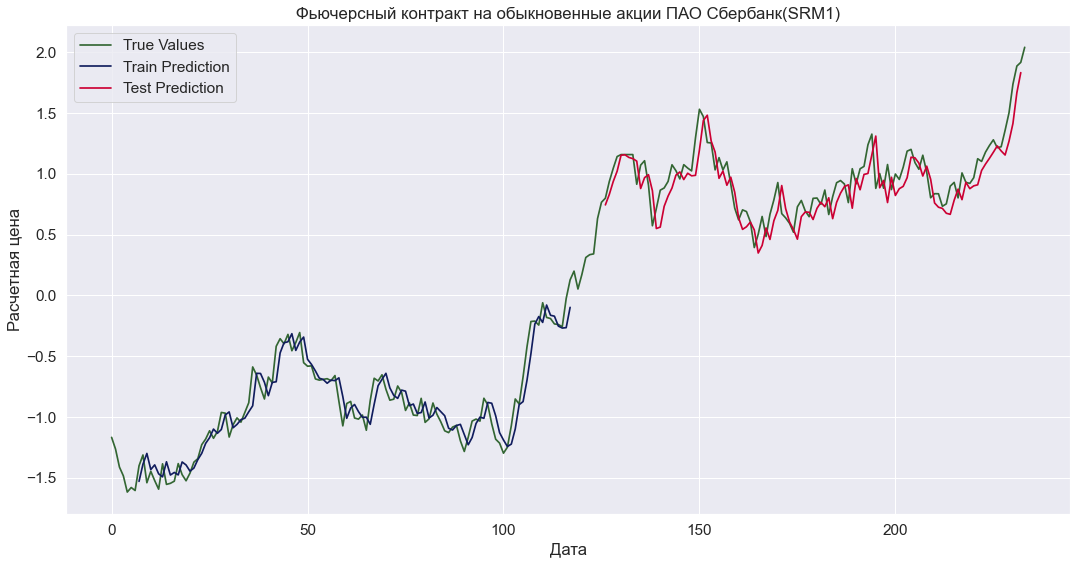

In [128]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_temp:len(trainPredict)+time_temp, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(time_temp*2)+1:len(dataset)-1, :] = testPredict

fig, ax = plt.subplots(figsize=(18, 9))
plt.plot(minmax_scaler.inverse_transform(dataset), label = 'True Values', color='#336633', linewidth=1.7)
plt.plot(trainPredictPlot, label='Train Prediction', color='#111d5e', linewidth=1.7)
plt.plot(testPredictPlot, label = 'Test Prediction', color='#CC0033', linewidth=1.7)
plt.xlabel('Дата')
plt.ylabel('Расчетная цена')
plt.title('Фьючерсный контракт на обыкновенные акции ПАО Сбербанк(SRM1)')
plt.legend()
plt.show()

# fig.savefig('./graphics/SBRF_Time_Series_Forecasting.png')